### This document explores advanced fitting of the hydrolysis data, such as fitting the curves obtained to the full solution (Lambert Function)

Throughout this document, the following naming conventions apply: 

$A$ = ATP concentration

$t$ = time

$K_T$ = Michaelis Menten constant for ATP

$K_D$ = Michaelis Menten constant for ADP

$\gamma$ = Hydrolysis Rate 

$m_o$ = Monomeric motor concentration, usually a constant

Note on how hydrolysis rate is reported: 

#### Part 1
Let's start with a simplified model for ATP hydrolysis: 

$\frac{dA}{dt} = - \gamma m_o \frac{\frac{A}{K_T}}{1 +\frac{A}{K_T}}$

At this time, we ignore $K_D$ and $K_P$.
We can non-dimensionalize it by considering $\hat{A} = \frac{A}{K_T}$. The non-dimensionalized equation becomes:

$\frac{d\hat{A}}{dt} = -\frac{\gamma m_o}{K_T} \frac{\hat{A}}{1 +\hat{A}}$

$K_T$ is a constant that has been experimentally quantified. We know the monomeric kinesin concentration we add into the experiment. From this information, we can extract the hydrolysis rate $\gamma$.

Plotting an ideal $\frac{dA}{dt}$ vs $- \gamma m_o \frac{\frac{A}{K_T}}{1 +\frac{A}{K_T}}$, we would obtain a straight line making a 45 degree angle to the x-axis. How does real data compare?


In [1]:
#### ------------- Relevant Imports ------------- ####
# Numpy imports:    
import numpy as np

# Pandas for csv 
import pandas as pd

# for extracting filenames 
import glob

#Matplotlib imports
import matplotlib.pyplot as plt

# skimage submodules we need
import skimage.io

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

import os

import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

import pandas as pd
import ast

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.themes import Theme
from bokeh.models import Range1d

import numpy as np
# Enable inline plotting in Jupyter Notebook
# output_notebook()

In [2]:
data_location = '../../analyzed_data/atp-hydro/ATP.csv';
# Read the CSV file into a DataFrame
df1 = pd.read_csv(data_location); 

data_location = '../../analyzed_data/atp-hydro/ADP.csv';
# Read the CSV file into a DataFrame
df2 = pd.read_csv(data_location); 

data_location = '../../analyzed_data/atp-hydro/Phosphate.csv';
# Read the CSV file into a DataFrame
df3 = pd.read_csv(data_location); 

df1

,Unnamed: 0,Data Location,ATP Concentration (uM),ADP Concentration (uM),P Concentration (uM),NCD Micro Motor Concentration (uM),r-squared for exponential fit,Tau (s),A0 (uM),Ainf (uM),...,"Cal_Param [Km, Rmax, Rmin, n]",Frame Interval (s),480 Channel Exposure Time (s),405 Channel Exposure Time (s),A81D Concentration (nM),Time Array (s),ATP Curve (uM),Bound Curve,Unbound Curve,Ratio (A.U.)
0,0,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,0,0,0,1,NaN,NaN,NaN,NaN,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[5.667104596897517, 8.3388460323697, 8.3295190...","[807.9173269803757, 715.4370927579171, 713.957...","[680.7845282970292, 572.5808678463503, 571.496...","[1.1867445475022282, 1.249495281686397, 1.2492..."
1,1,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1000,0,0,1,0.978427,5440.119656,4.936754e+02,2.156594e+01,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[364.5141775042381, 566.8489055790179, 562.094...","[1187.102834964457, 871.5993725147126, 870.901...","[384.8399986372975, 273.3118593571996, 273.230...","[3.0846659369294747, 3.1890287328351636, 3.187..."
2,2,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,100,0,0,1,-1.273953,281.107839,2.340975e+01,1.494248e+00,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[15.41510051380279, 14.938781692684056, 11.811...","[854.7907844923425, 735.4185322424313, 723.868...","[605.1621106392813, 524.6044682931588, 544.004...","[1.4124988485967147, 1.4018533517931564, 1.330..."
3,3,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1420,0,0,1,0.903739,7050.907731,4.821327e+02,3.839475e+01,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[381.13642499300414, 631.7276451050066, 584.04...","[1169.0179047866725, 853.8649287011839, 851.23...","[377.43695588022683, 266.12453635367746, 266.4...","[3.097253426232169, 3.2085163600488307, 3.1946..."
4,4,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,200,0,0,1,0.921534,1246.332904,1.253006e+02,1.363331e-24,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[100.14061347588706, 115.62749007325766, 105.9...","[1193.4635054635908, 860.5297790529672, 856.02...","[482.0123390696243, 335.3673106695865, 340.789...","[2.4760019790514134, 2.565932193375835, 2.5118..."
5,5,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,300,0,0,1,0.961366,1704.867361,1.852150e+02,1.262279e+00,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[159.75231989359256, 179.12031971913288, 166.8...","[980.2019284919894, 851.5675292622191, 848.978...","[356.37171800924017, 303.16273211425323, 306.1...","[2.750504259899138, 2.8089452925938403, 2.7732..."
6,6,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,470,0,0,1,0.981568,2529.714521,2.911378e+02,4.905710e+00,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[251.52796247272224, 296.13714054774647, 276.2...","[963.456007299359, 835.5678307086743, 832.2171...","[325.58496300486894, 276.7574486368725, 277.90...","[2.9591538823153547, 3.0191340280962224, 2.994..."
7,7,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,800,0,0,1,0.984706,4102.036731,4.740735e+02,1.439831e+01,...,"[67.60201128, 3.36417414, 1.06783864, 1.17289855]",20,0.1,0.15,1400,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[410.3060096675999, 533.5969736474292, 497.043...","[1032.3136289758781, 891.2822054113948, 887.58...","[331.18926436814627, 280.52379131033604, 280.6...","[3.1169900115734728, 3.1772071853449066, 3.162..."
8,8,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,50,0,0,1,NaN,1999.999996,5.000000

In [3]:
#### ------------- Load and Read Data ------------- ####
ATP_conc_list = []
ADP_conc_list = []
P_conc_list = []
ATP_curve_list = []
ratio_curve_list = []
linear_r2_list = []
exponential_r2_list = []
linear_hydrolysis_rate_list = []
exponential_hydrolysis_rate_list = []
times_list = []
data_locations_list = []

for df in [df1]:
# for df in [df1, df2, df3]: 
    # ATP Concentrations
    ATP_conc_list.append(np.array(df["ATP Concentration (uM)"])); 

    # ADP Concentrations
    ADP_conc_list.append(np.array(df["ADP Concentration (uM)"])); 

    # Phosphate Concentrations
    P_conc_list.append(np.array(df["P Concentration (uM)"])); 

    # ATP Curves
    ATP_curve_list.append([ast.literal_eval(df["ATP Curve (uM)"][i]) for i in range(len(df))])

    # Ratio Curves
    ratio_curve_list.append([ast.literal_eval(df["Ratio (A.U.)"][i]) for i in range(len(df))])

    # Goodness of Fit
    linear_r2_list.append(np.array(df["r-squared for linear fit"])); 
    exponential_r2_list.append(np.array(df["r-squared for exponential fit"])); 

    # Hydrolysis Rate
    linear_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Linear Fitting (-abs(Slope)/Motconc)"])); 
    exponential_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Exponential Curve"])); 

    # Time
    times_list.append([ast.literal_eval(df["Time Array (s)"][i]) for i in range(len(df))])
    
    # Data location
    data_locations_list.append(df["Data Location"])
    
ATP_conc_list = [item for sublist in ATP_conc_list for item in sublist]; 
ADP_conc_list = [item for sublist in ADP_conc_list for item in sublist];
P_conc_list = [item for sublist in P_conc_list for item in sublist];
ATP_curve_list = [item for sublist in ATP_curve_list for item in sublist];
ratio_curve_list = [item for sublist in ratio_curve_list for item in sublist];
linear_r2_list = [item for sublist in linear_r2_list for item in sublist];
exponential_r2_list = [item for sublist in exponential_r2_list for item in sublist];
linear_hydrolysis_rate_list = [item for sublist in linear_hydrolysis_rate_list for item in sublist];
exponential_hydrolysis_rate_list = [item for sublist in exponential_hydrolysis_rate_list for item in sublist];
times_list = [item for sublist in times_list for item in sublist];
data_locations_list = [item for sublist in data_locations_list for item in sublist]; 





In [4]:
len(P_conc_list)
print(data_locations_list)

['/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/0uMATP', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/1000uMATP_1', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/100uMATP_1', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/1420uMADP_1', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/200uMATP_1', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/300uMATP_1', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/470uMATP_1', '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/800uMATP_1', '

findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans.


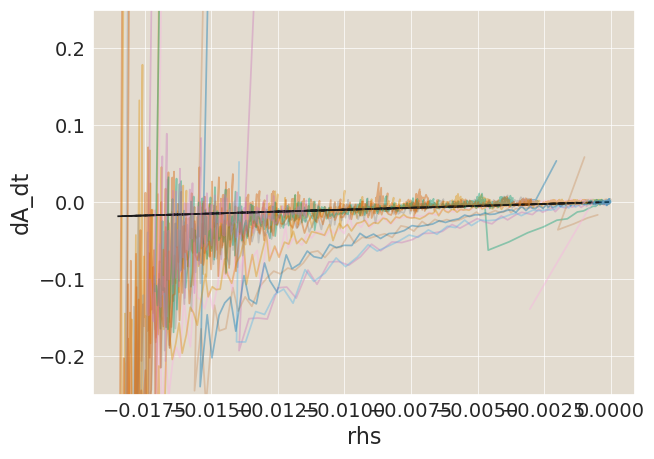

In [5]:
# Assume K_T  value 
K_T = 50; #uM

# Motor concentration 
m_o = 1; #uM


for i in range(len(ATP_curve_list)):

    A = ATP_curve_list[i]
    
    if A != []:
        # Non dimensionalize a curve
        A_nd = np.array(ATP_curve_list[i])/K_T
        time = times_list[i]

        # Get first differential
        dA_dt = np.diff(A_nd)

        # Get rhs term of the equation
        rhs = -(m_o/K_T)*(A_nd)/(1 + A_nd)
#         print(rhs)
        # # Plots
        # plt.plot(time, A)
        # plt.xlabel("time")
        # plt.ylabel("ATP conc")

        # plt.figure()
        # plt.plot(time, A_nd)
        # plt.plot(time[:5], A_nd[:5], 'or')

        # plt.plot(time[:-1], dA_dt)
        # plt.plot(time[:5], dA_dt[:5], 'or')
        # plt.xlabel("time")
        # plt.ylabel("A_hat")

        # plt.figure()
        plt.plot(rhs[:-1], dA_dt, alpha = 0.4)
        # plt.plot(rhs[:5], dA_dt[:5], 'or')
        plt.xlabel("rhs")
        plt.ylabel("dA_dt")
        plt.ylim([-0.25,0.25])
        # Plot a 45 degree line
        plt.plot(np.arange(min(rhs), max(rhs), 0.001), np.arange(min(rhs), max(rhs), 0.001), '--k')
    

#### Part 2

The solution to the equation $\frac{d\hat{A}}{dt} = -\frac{\gamma m_o}{K_T} \frac{\hat{A}}{1 +\hat{A}}$ is 

$\hat{A} + ln(\hat{A}) = - \frac{- \gamma m_o}{K_T}t + C$

What does plotting $\hat{A} + ln(\hat{A})$ vs time look like?

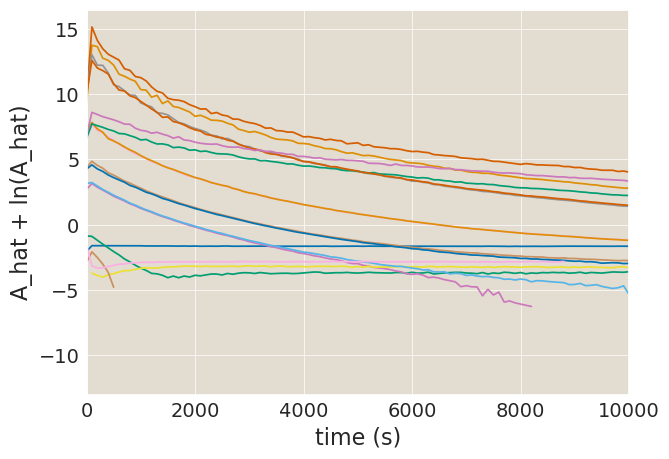

In [6]:
i = 10; 

# Assume K_T  value 
K_T = 50; #uM

# Motor concentration 
m_o = 1; #uM


for i in range(len(ATP_curve_list)):
    A = ATP_curve_list[i]

    # Non dimensionalize a curve
    A_nd = np.array(ATP_curve_list[i])/K_T
    time = times_list[i]

    # Get first differential
    dA_dt = np.diff(A_nd)

    # Get rhs term of the equation
    rhs = -(m_o/K_T)*(A_nd)/(1 + A_nd)

    # Plots
    plt.plot(time, A_nd + np.log(A_nd))
    plt.ylabel('A_hat + ln(A_hat)')
    plt.xlabel('time (s)')

    # plt.ylim([0, 20])
    plt.xlim([0, 10000])

What if we consider K effective instead, where 

\begin{align}
 K_{eff} = \frac{1 + y_o*(\frac{1}{K_D} + \frac{1}{K_P})}{\frac{1}{K_T} - \frac{1}{K_D} + \frac{1}{K_P}} \,.
\end{align}

How does $K_{eff}$ vary with $y_o$?

0.029012845215157353 0.03558718861209964


Text(0.5, 1.0, 'K_eff vs ATP Concentration')

findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans.


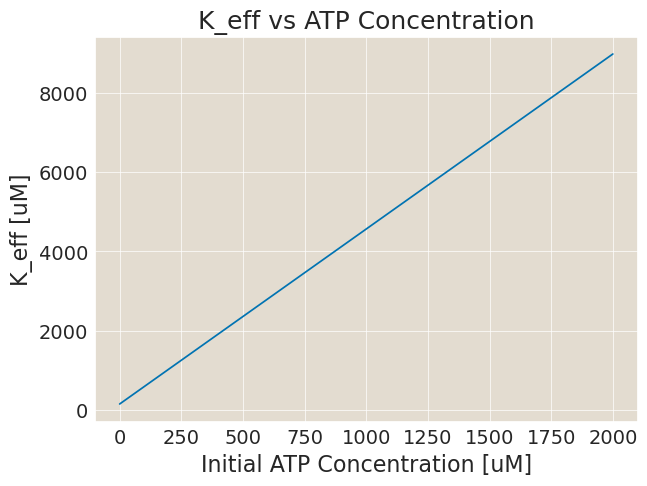

In [7]:
K_T = 28.1; 
 
K_D = 34.6; #uM

K_P = 9000; #uM 

K_inv = (1/K_D) + (1/K_P); #uM-1 

print(K_inv, 1/K_T)

y_o_list = np.arange(0, 2000)

K_eff_func = lambda y_o: (1 + (y_o*K_inv))/((1/K_T) - K_inv) # Units uM

K_eff_list = K_eff_func(y_o_list)
plt.plot(y_o_list, K_eff_list)
plt.xlabel("Initial ATP Concentration [uM]")
plt.ylabel("K_eff [uM]")
plt.title("K_eff vs ATP Concentration")

Setting up fitting functions:

In [8]:
### Fitting parameters

def line(x, slope, cutoff): 
    return -slope*x + cutoff

#Curve-fit to the Langmuir curve
def fitting(data, time_curve, p0):
    """
    Performs a curve fitting using scipy.optimize.curve_fit 
    
    Parameters
    p0 = 1D list with 4 entries of parameter guesses
    
    Returns
    param = 1D list with fit values of each parameter
    curve = 1D array of intensity values for every concentration in xvals
    xvals = 1D array from 0 to maxconc with step size 1
    """
    
    
    #Curve fits and returns parameter values as well as the covarience
    param, param_cov = curve_fit(line, 
                                 data, 
                                 time_curve, 
                                 p0, 
                                 #bounds = (-np.ones([2])*np.inf, np.ones([2])*np.inf)
                                )

    #stores the new function information according to the coefficients given by curve-fit() function 

    curve = line(time, param[0], param[1])
    
    print(param, param_cov)
    return param, param_cov

### Formulae for reference:

Non-dimensionalisation of ATP curve: 

\begin{align}
\hat{y} = \frac{y}{K}, \text{ where } K = K_T \text{ or } K = K_{eff}
\end{align}

Choice of rate constants: 

K_T = 28.1 uM

K_D = 34.6 uM

K_P = 9000 uM 


<!-- \begin{align}
K_{eff} = \frac{K_T*(1 + y_o*(\frac{1}{K_D} + \frac{1}{K_P}))}{\gamma*m}
\end{align}
 -->
\begin{align}
 K_{eff} = \frac{1 + y_o*(\frac{1}{K_D} + \frac{1}{K_P})}{\frac{1}{K_T} - \frac{1}{K_D} + \frac{1}{K_P}} \,.
\end{align}


Scaling Time:

<!-- \begin{align}
\hat{t} = \frac{t * \gamma*m}{K_T*(1 + y_o*(\frac{1}{K_D} + \frac{1}{K_P})}
\end{align}
 -->
 
\begin{align}
\hat{t} = \frac{t * \gamma*m}{K_T*(1 + y_o*(\frac{1}{K_D} + \frac{1}{K_P})}
\end{align}


Reporting hydrolysis rate: 

We know concentration of motors $m = 1$uM. Assume $\gamma = 1 s^{-1}$.

Plot $\hat{y} - \hat{y_o} + ln(\frac{\hat{y}}{\hat{y_o}}) = -\hat{t}$ and fit linear curve. Then, $\gamma' = slope$. If we obtain $slope = 1$, then $\gamma' = \gamma = 1$. Otherwise, $\gamma'$ gives the "corrected" hydrolysis rate.

<!-- \begin{align}
\gamma = \frac{slope*K_T*(1 + y_o*(\frac{1}{K_D} + \frac{1}{K_T}))}{m} \text{, units $s^{-1}$.}
\end{align} -->


<!-- Note that for the above choice of menten constants, for $y_o = 1410 uM$,

\begin{align}
\frac{K_T*(1 + y_o*(\frac{1}{K_D} + \frac{1}{K_T}))}{m} \approx 1177
\end{align} -->

The above is compared to the linear hydrolysis rate, which is obtained by fitting a linear curve to the initial part of the ATP vs time curve, and asserting $\gamma_l = \frac{slope}{m}$.

/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/3325848596.py:86: RuntimeWarning: divide by zero encountered in divide
  plot1.line(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/3325848596.py:88: RuntimeWarning: divide by zero encountered in divide
  plot1.circle(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/3325848596.py:96: RuntimeWarning: divide by zero encountered in divide
  plot2.line(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/3325848596.py:98: RuntimeWarning: divide by zero encountered in divide
  plot2.circle(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)),


Initial ATP conc:  0
P conc:  0
Initial ATP conc:  1000
P conc:  0
[ 0.24856507 -0.69334515] [[0.00012419 0.00017671]
 [0.00017671 0.00028403]]
[1.09741235e-01 5.34554186e+02] [[3.41246362e-05 4.09495643e-02]
 [4.09495643e-02 5.55094104e+01]]


/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/3325848596.py:102: RuntimeWarning: divide by zero encountered in divide
  y3 = A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff));


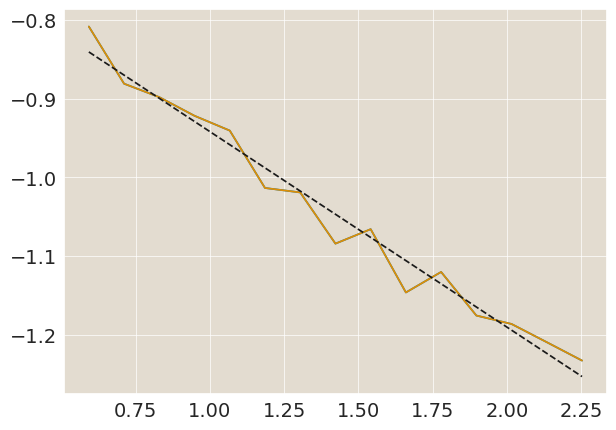

Initial ATP conc:  100
P conc:  0
[ 0.14790596 -2.70893855] [[0.00023719 0.00259632]
 [0.00259632 0.03210419]]
[2.82766770e-03 5.32351618e+00] [[2.17248980e-07 2.60698775e-04]
 [2.60698775e-04 3.53391672e-01]]


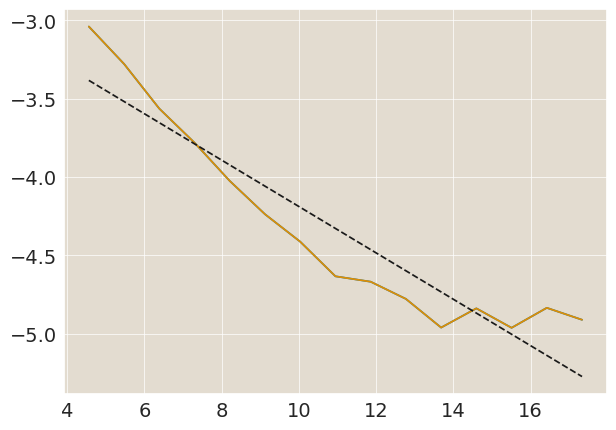

Initial ATP conc:  1420
P conc:  0
[ 0.34562021 -1.00484291] [[0.000183   0.00018519]
 [0.00018519 0.00021171]]
[1.18392244e-01 5.72637077e+02] [[3.29665732e-05 3.95598878e-02]
 [3.95598878e-02 5.36256258e+01]]


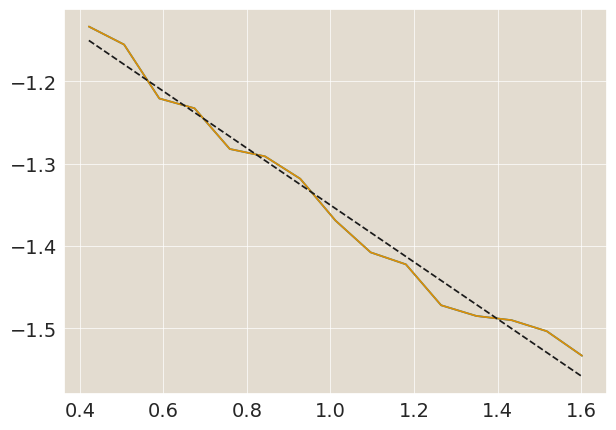

Initial ATP conc:  200
P conc:  0
[ 0.16058902 -0.56225117] [[3.51542484e-07 2.20688542e-06]
 [2.20688542e-06 1.56501256e-05]]
[3.97899983e-02 9.87107233e+01] [[2.51338351e-06 3.01606023e-03]
 [3.01606023e-03 4.08843722e+00]]


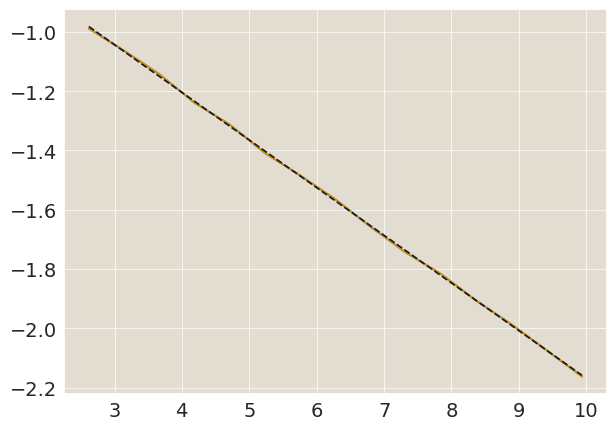

Initial ATP conc:  300
P conc:  0
[ 0.16992528 -0.57622921] [[7.94415790e-07 3.49605743e-06]
 [3.49605743e-06 1.73798220e-05]]
[5.48547767e-02 1.60527150e+02] [[3.25644205e-06 3.90773044e-03]
 [3.90773044e-03 5.29714566e+00]]


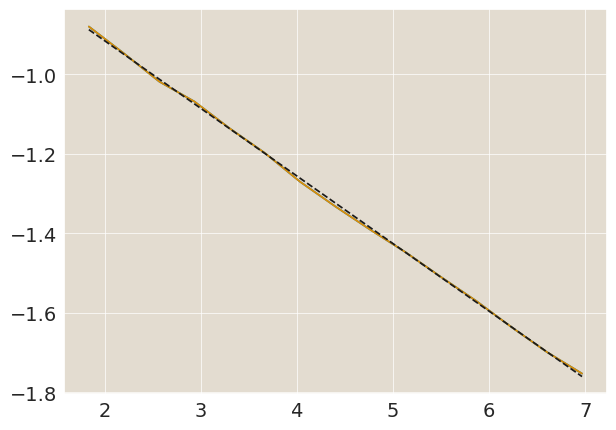

Initial ATP conc:  470
P conc:  0
[ 0.18263288 -0.55244047] [[4.54235511e-06 1.32535585e-05]
 [1.32535585e-05 4.36837579e-05]]
[7.50640531e-02 2.73514741e+02] [[5.20235041e-06 6.24282048e-03]
 [6.24282048e-03 8.46248997e+00]]


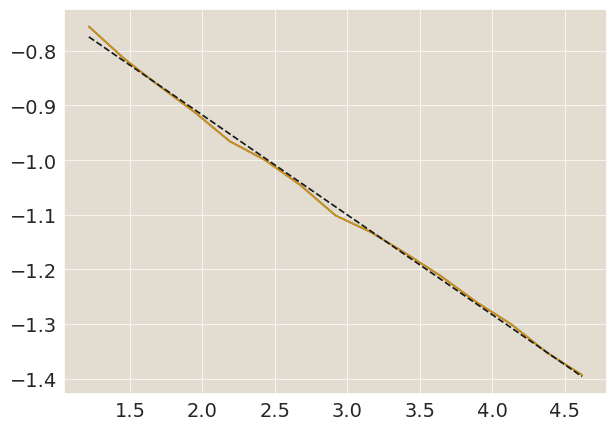

Initial ATP conc:  800
P conc:  0
[ 0.21642884 -0.55966652] [[2.78401819e-05 4.91074357e-05]
 [4.91074357e-05 9.78494796e-05]]
[1.02882455e-01 4.78404194e+02] [[1.02974118e-05 1.23568941e-02]
 [1.23568941e-02 1.67504565e+01]]


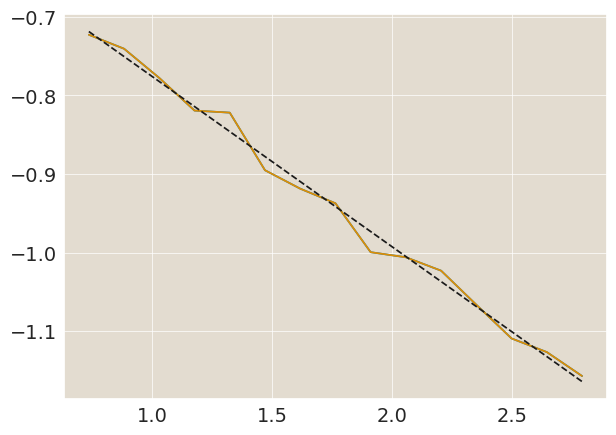

Initial ATP conc:  50
P conc:  0
[-0.01983178 -3.88026977] [[3.85534476e-06 7.27813881e-05]
 [7.27813881e-05 1.52573070e-03]]
[-4.74406810e-04  1.10610926e+00] [[1.56581287e-09 2.03555672e-06]
 [2.03555672e-06 2.93850880e-03]]


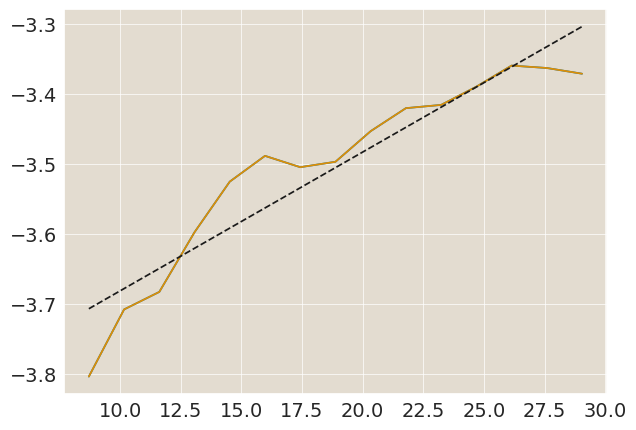

Initial ATP conc:  200
P conc:  0
[ 0.15982108 -0.53963791] [[3.91078654e-07 2.45508243e-06]
 [2.45508243e-06 1.74102142e-05]]
[4.06717466e-02 1.01089045e+02] [[2.85582135e-06 3.42698565e-03]
 [3.42698565e-03 4.64546949e+00]]


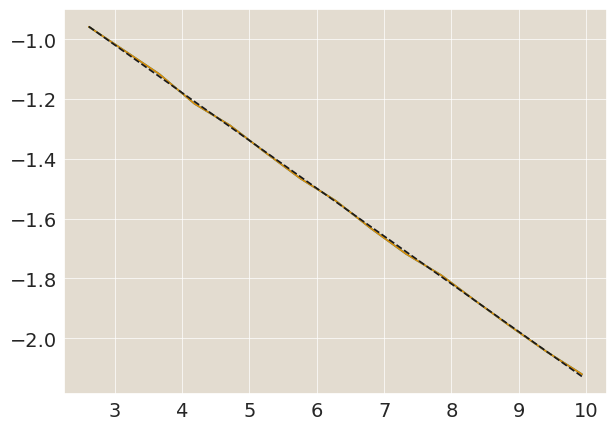

Initial ATP conc:  300
P conc:  0
[ 0.16606752 -0.63073295] [[1.34179559e-06 5.90496124e-06]
 [5.90496124e-06 2.93551171e-05]]
[5.17992141e-02 1.53464192e+02] [[2.68705949e-06 3.22447140e-03]
 [3.22447140e-03 4.37095015e+00]]


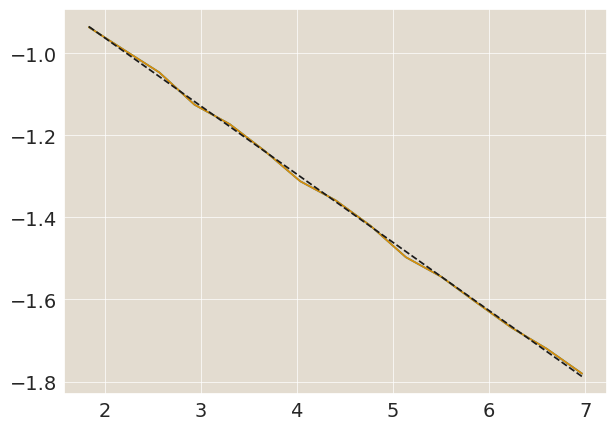

Initial ATP conc:  470
P conc:  0
[ 0.18103308 -0.55014154] [[3.27682383e-06 9.56102634e-06]
 [9.56102634e-06 3.15131641e-05]]
[7.48392205e-02 2.74378856e+02] [[4.46283668e-06 5.35540399e-03]
 [5.35540399e-03 7.25954758e+00]]


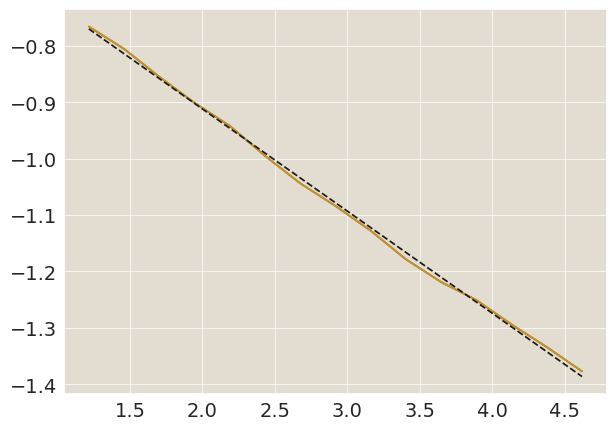

Initial ATP conc:  1000
P conc:  0
[ 0.15475818 -1.37032837] [[3.06254809e-05 4.35763320e-05]
 [4.35763320e-05 7.00413486e-05]]
[4.21630145e-02 2.91956818e+02] [[2.81937736e-06 3.38325282e-03]
 [3.38325282e-03 4.58618715e+00]]


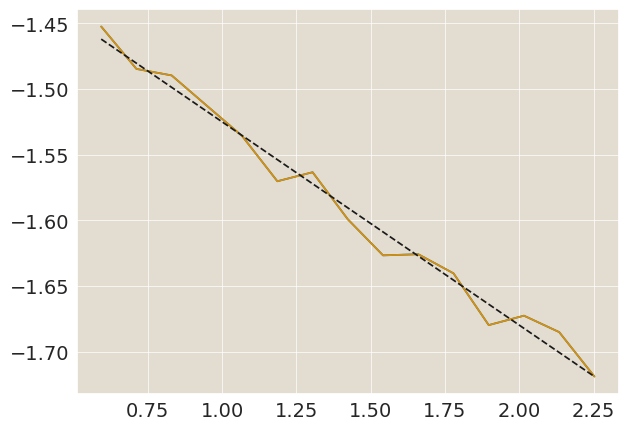

Initial ATP conc:  800
P conc:  0
[ 0.22333946 -0.5596518 ] [[2.70503382e-05 4.77142259e-05]
 [4.77142259e-05 9.50734257e-05]]
[1.05187967e-01 4.77418140e+02] [[1.04282370e-05 1.25138844e-02]
 [1.25138844e-02 1.69632655e+01]]


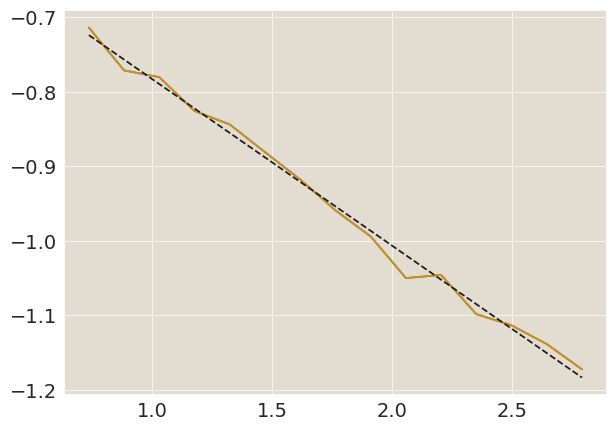

Initial ATP conc:  1420
P conc:  0
[ 0.21185935 -1.61570497] [[9.62766629e-05 9.74320000e-05]
 [9.74320000e-05 1.11382838e-04]]
[4.70117940e-02 3.29509131e+02] [[5.85128659e-06 7.02154394e-03]
 [7.02154394e-03 9.51809291e+00]]


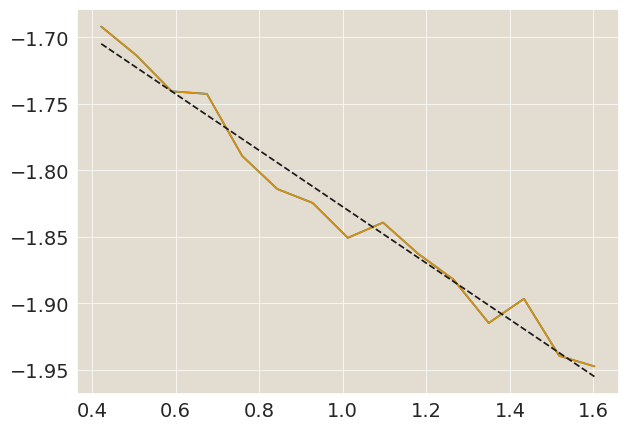

Initial ATP conc:  100
P conc:  0
Initial ATP conc:  50
P conc:  0
[-0.01050601 -3.28784602] [[2.68984553e-06 4.68729578e-05]
 [4.68729578e-05 9.22684978e-04]]
[-3.72993456e-04  2.10540206e+00] [[2.97489946e-09 3.56987937e-06]
 [3.56987937e-06 4.83916985e-03]]


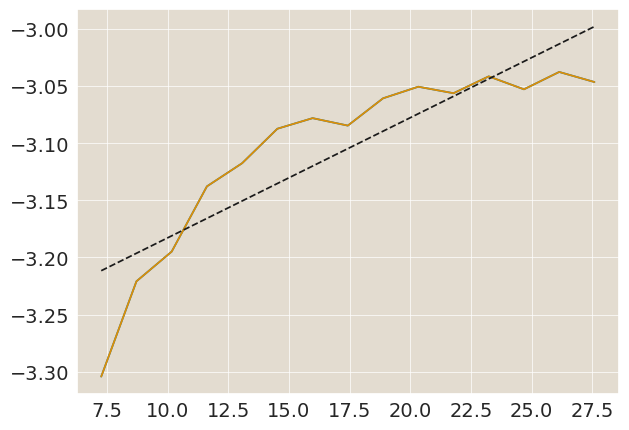

In [9]:
fitting_information = [];

# Pandas dataframe
m = 1; #motor concentration (uM)

# For an ideal curve
gamma = 1; # assume hydrolysis rate = 1 ATP/motor/s (s-1)

# Plotting properties
line_size = 2;
size = 600; 
plot1 = figure(title="Non dimensionalized ΑΤP vs Scaled Time (K_T and K_eff)", width=size, height=size)
plot2 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_T) vs Scaled Time", width=size, height=size)
plot3 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_eff) vs Scaled Time", width=size, height=size)
plot4 = figure(title="ATP vs Time", width=size, height=size)
plot5 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_eff) vs Time (s)", width=size, height=size)
plot6 = figure(title="log(ATP) vs Time", width=size, height=size)

n1, n2 = [5, 20]; # number of datapoints

for i in range(len(ATP_curve_list)): 
    
    #### --------- Reject Bad Curves --------- ####
    # ATP curve should not be empty 
    if len(ATP_curve_list[i]) != 0: 
#         break
    
        # If initial ATP value (according to probe) is too high, reject
        if ATP_curve_list[i][0] < 2000: 
    #         break
        
        
            #### --------- Initialisations --------- ####

            # Initial ATP Concentration
            y_o = ATP_conc_list[i]; #initial ATP concentration (according to experimental plan)
        #     y_o = ATP_curve_list[i][0]; #initial ATP concentration
        #     y_o_exp = ATP_conc_list[i];
            print('Initial ATP conc: ', y_o) 


        #     # Initial ADP Concentration
            ADP_o = ADP_conc_list[i]; 
            P_o = P_conc_list[i]; 
            print('P conc: ', P_o) 
            # Get time curve 
            time = np.array(times_list[i])

            # Generate a color
            color = plt.cm.viridis(y_o/800);
            color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255),
                                                 int(color[1] * 255),
                                                 int(color[2] * 255))

            #### --------- Without K_eff --------- ####
            A = ATP_curve_list[i]

            # Non-dimensionalise time
            idealised_time_constant_K_T = K_T/(gamma*m);
            time_nd_K_T = time/idealised_time_constant_K_T;

            # Non-dimensionalize a curve
            A_nd = np.array(ATP_curve_list[i])/K_T

            #### --------- With K_eff --------- ####

            K_eff = K_eff_func(y_o)

            # Non-dimensionalise time
        #     idealised_time_constant_K_eff = K_eff/(gamma*m);
            idealised_time_constant_K_eff = (K_T*(1 + (y_o*K_inv)))/(gamma*m);
            time_nd_K_eff = time/idealised_time_constant_K_eff; 

            # Non dimensionalise ATP 
            A_nd_K_eff = np.array(ATP_curve_list[i])/K_eff; 

            #### --------- Plots --------- ####

            plot1.line(time_nd_K_T, A_nd + np.log(A_nd), line_color=color, line_dash="dotted")
            plot1.circle(time_nd_K_T, A_nd + np.log(A_nd), size = 1, fill_color="white", line_color=color)

            # Data
        #     plot1.line(time_nd_K_eff, A_nd_K_eff + np.log(A_nd_K_eff), line_color=color, line_dash="dotted")
        #     plot1.circle(time_nd_K_eff, A_nd_K_eff + np.log(A_nd_K_eff), size = 1, fill_color="white", line_color="blue")

            plot1.line(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)), 
                       line_color=color, line_dash="dotted")
            plot1.circle(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)), 
                         size = 1, fill_color="white", line_color=color)

            # Ideal curve (45 degree line)
            plot1.line(np.arange(0, np.amax(time_nd_K_eff)), - np.arange(0, np.amax(time_nd_K_eff)), 
                       line_color="black", line_dash="dotted")

        #     plot2.line(time_nd_K_T, A_nd + np.log(A_nd), line_color=color, line_dash="dotted")
            plot2.line(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)), 
                       line_color=color, line_dash="dotted")
            plot2.circle(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)), 
                         size = 1, fill_color="white", line_color=color) 

            # Data
            y3 = A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff));
            plot3.line(time_nd_K_eff, y3, 
                       line_color=color, line_dash="dotted")
            plot3.circle(time_nd_K_eff, y3, 
                         size = line_size, fill_color="white", line_color=color)


            plot4.line(time, A, 
                       line_color=color, line_dash="dotted", line_width = line_size)
            plot4.circle(time, A, 
                         size = line_size, fill_color="white", line_color=color)

            plot5.line(time, y3, 
                       line_color=color, line_dash="dotted")
            plot5.circle(time, y3, 
                         size = line_size, fill_color="white", line_color=color)

            plot6.line(time, np.log(A), 
                       line_color=color, line_dash="dotted")
            plot6.circle(time, np.log(A), 
                         size = line_size, fill_color="white", line_color=color)
            #### --------- Fitting --------- ####

            # Ignore if infs. This usually corresponds to y_o = 0; 
            if np.all(np.isinf(y3[n1:n2])) != True and len(y3[n1:n2]) >=2: 
                plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2])
                params, param_cov = fitting(time_nd_K_eff[n1:n2], y3[n1:n2], [1,1]);

                linear_params, linear_param_cov = fitting(time[n1:n2], A[n1:n2], [1,1]);

                plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2])
                plt.plot(time_nd_K_eff[n1:n2], line(time_nd_K_eff[n1:n2], params[0], params[1]), '--k')
                plt.show()

                fitting_information.append(
                {
                    'Data Location': data_locations_list[i],
                    'Data Index': i,
                    'Initial ATP Conc': y_o,
                    'Initial ADP Conc': ADP_o,
                    'Initial Phosphate Conc': P_o,
                    'Fitted Parameters (-Slope, Y-intercept)':  params, 
                    'Fitting Covariance Matrix': param_cov,
        #             'Hydrolysis Rate': params[0]*K_T*(1 + y_o*K_inv)/m,
                    'Hydrolysis Rate': params[0],
                    'Linear Hydrolysis Rate': linear_params[0]/m, 
                    'Time': time_nd_K_eff, 
                    'Non-Dimensionalised Data': y3
                }
                )

# Add color bar
mapper = linear_cmap(field_name='color', palette=Viridis256, low=0, high=800)
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0))
plot1.add_layout(color_bar, 'right')
plot2.add_layout(color_bar, 'right')
plot3.add_layout(color_bar, 'right')
plot4.add_layout(color_bar, 'right')
plot5.add_layout(color_bar, 'right')

# Labels 
plot1.xaxis.axis_label = "Scaled Time"
plot1.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_T/K_eff"

plot2.xaxis.axis_label = "Scaled Time"
plot2.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_T"

plot3.xaxis.axis_label = "Scaled Time"
plot3.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_eff"

plot4.xaxis.axis_label = "Time (s)"
plot4.yaxis.axis_label = "ATP (uM)"

plot5.xaxis.axis_label = "Time (s)"
plot5.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_eff"

# Ideal line 
plot3.line(np.arange(0,np.amax(time_nd_K_eff)), - np.arange(0,np.amax(time_nd_K_eff)), line_color="black")

#         # Arrange the plots in a grid layout
#         grid = gridplot([[plot4, plot6, plot2], [plot5, plot3]])

#         # Show the grid layout
#         show(grid)

fitting_information = pd.DataFrame(fitting_information)

In [10]:
print(K_T*(1 + 141*K_inv)/m)

143.05179402697496


In [11]:
fitting_information

,Data Location,Data Index,Initial ATP Conc,Initial ADP Conc,Initial Phosphate Conc,"Fitted Parameters (-Slope, Y-intercept)",Fitting Covariance Matrix,Hydrolysis Rate,Linear Hydrolysis Rate,Time,Non-Dimensionalised Data
0,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1,1000,0,0,"[0.24856507360360244, -0.6933451528665987]","[[0.0001241923423496001, 0.0001767105892396188...",0.248565,0.109741,"[0.0, 0.11857319210151755, 0.2371463842030351,...","[-1.148393629805576, -0.6625446664112333, -0.6..."
1,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,2,100,0,0,"[0.14790595842866172, -2.7089385528516483]","[[0.000237187074404899, 0.002596320646365398],...",0.147906,0.002828,"[0.0, 0.912191572181801, 1.824383144363602, 2....","[-2.012362880912529, -2.0445525131553524, -2.2..."
2,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,3,1420,0,0,"[0.3456202133642836, -1.0048429095691307]","[[0.00018299702907446003, 0.000185193026054343...",0.345620,0.118392,"[0.0, 0.08433334764382316, 0.16866669528764633...","[-1.477106207337035, -0.9327639629435507, -1.0..."
3,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,4,200,0,0,"[0.16058902097811828, -0.5622511677355971]","[[3.5154248414710087e-07, 2.206885416408685e-0...",0.160589,0.039790,"[0.0, 0.5231433652048713, 1.0462867304097425, ...","[-0.7882511455939003, -0.6294854541607557, -0...."
4,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,5,300,0,0,"[0.16992528062862766, -0.5762292116641912]","[[7.94415789692126e-07, 3.4960574329411447e-06...",0.169925,0.054855,"[0.0, 0.36673253955641477, 0.7334650791128295,...","[-0.7251754113726802, -0.5976204841508987, -0...."
5,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,6,470,0,0,"[0.18263287594665287, -0.5524404726009104]","[[4.542355106505253e-06, 1.3253558516981277e-0...",0.182633,0.075064,"[0.0, 0.24314770454254458, 0.48629540908508917...","[-0.723313711776014, -0.540007276939164, -0.61..."
6,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,7,800,0,0,"[0.21642884077342445, -0.5596665188228708]","[[2.7840181932165626e-05, 4.9107435702822355e-...",0.216429,0.102882,"[0.0, 0.14699208038391726, 0.2939841607678345,...","[-0.7735305749598841, -0.4773131185498028, -0...."
7,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,8,50,0,0,"[-0.019831783211539927, -3.8802697704292552]","[[3.855344762546521e-06, 7.278138814574109e-05...",-0.019832,-0.000474,"[1.4521576315710074, 2.904315263142015, 4.3564...","[-3.885310699154396, -4.059252722574938, -4.19..."
8,/Volumes/Najma/ATP/2_variation of ATP/200uMATP_2,9,200,0,0,"[0.15982107550883326, -0.5396379118286465]","[[3.910786539868677e-07, 2.455082428947777e-06...",0.159821,0.040672,"[0.0, 0.5231433652048713, 1.0462867304097425, ...","[-0.6294639462728046, -0.6046789880614003, -0...."
9,/Volumes/Najma/ATP/2_variation of ATP/300uMATP_2,10,300,0,0,"[0.1660675235112091, -0.6307329536881968]","[[1.3417955947488963e-06, 5.904961236621796e-0...",0.166068,0.051799,"[0.0, 0.36673253955641477, 0.7334650791128295,...","[-0.7509620778645019, -0.665661979147843, -0.7..."


In [12]:
fitting_information["Data Location"].values

array(['/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/1000uMATP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/100uMATP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/1420uMADP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/200uMATP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/300uMATP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/470uMATP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1uMmicro_1400nM_A81D_2/800uMATP_1',
       '/Volumes/Najma/ATP/1_variation of ATP/Nikon_10X_bin1_20sFrameInter

### Visualising Hydrolysis Rate Distribns

In [13]:
# plot6 = figure(title="Non dimensionalized ΑΤP vs Time (K_eff)", width=size, height=size)
plot7 = figure(title="Rate vs ATP (From K_eff fit)", width=size, height=size)
plot8 = figure(title="Rate vs ATP (From Linear fit)", width=size, height=size)
plot9 = figure(title="Rate vs ADP (From K_eff fit)", width=size, height=size)
plot10 = figure(title="Rate vs ADP (From Linear fit)", width=size, height=size)
plot11 = figure(title="Rate vs P (From K_eff fit)", width=size, height=size)
plot12 = figure(title="Rate vs P (From Linear fit)", width=size, height=size)
circle_size = 10;

# plt.figure()
# plt.hist(fitting_information["Hydrolysis Rate"], bins = 100);
# plt.xlabel("Hydrolysis Rate (s-1)")
# plt.ylabel("Count")

print()

# plt.figure()
plot7.circle(fitting_information["Initial ATP Conc"], fitting_information["Hydrolysis Rate"], size = circle_size);
plot7.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot7.xaxis.axis_label = "ATP[t=0] (uM), Experimental Plan"

plot8.circle(fitting_information["Initial ATP Conc"], fitting_information["Linear Hydrolysis Rate"], size = circle_size);
plot8.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot8.xaxis.axis_label = "ATP[t=0] (uM), Experimental Plan"

plot9.circle(fitting_information["Initial ADP Conc"], fitting_information["Hydrolysis Rate"], size = circle_size);
plot9.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot9.xaxis.axis_label = "ADP[t=0] (uM), Experimental Plan"

plot10.circle(fitting_information["Initial ADP Conc"], fitting_information["Linear Hydrolysis Rate"], size = circle_size);
plot10.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot10.xaxis.axis_label = "ADP[t=0] (uM), Experimental Plan"

plot11.circle(fitting_information["Initial Phosphate Conc"], fitting_information["Hydrolysis Rate"], size = circle_size);
plot11.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot11.xaxis.axis_label = "P[t=0] (uM), Experimental Plan"

plot12.circle(fitting_information["Initial Phosphate Conc"], fitting_information["Linear Hydrolysis Rate"], size = circle_size);
plot12.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot12.xaxis.axis_label = "P[t=0] (uM), Experimental Plan"

# # Arrange the plots in a grid layout
# grid = gridplot([[plot7, plot8], [plot9, plot10], [plot11, plot12]])

# # Show the grid layout
# show(grid)

### Visualising Individual Fits

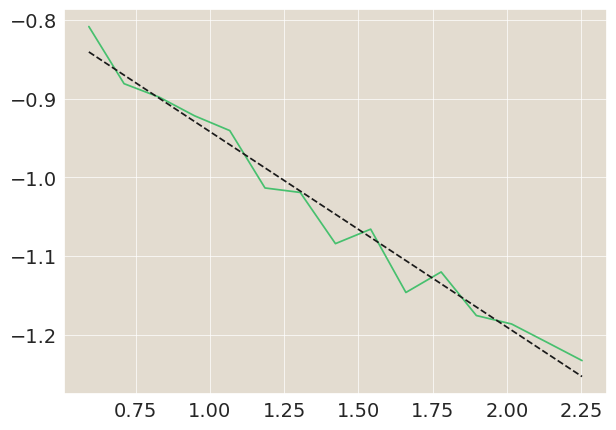

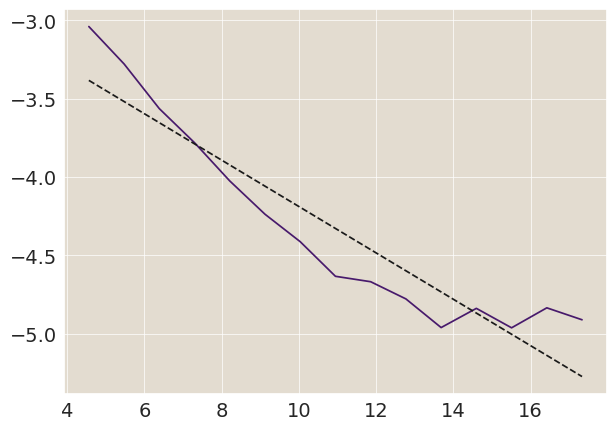

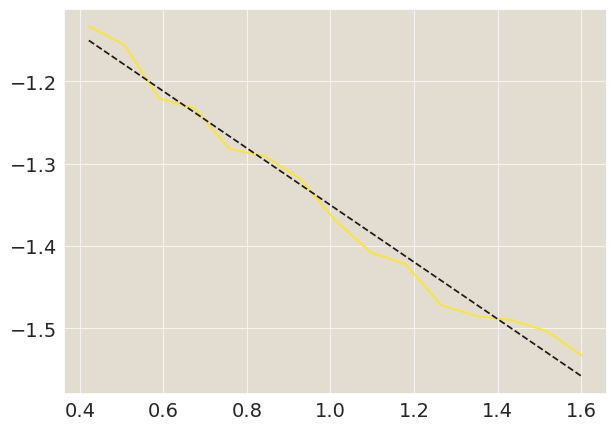

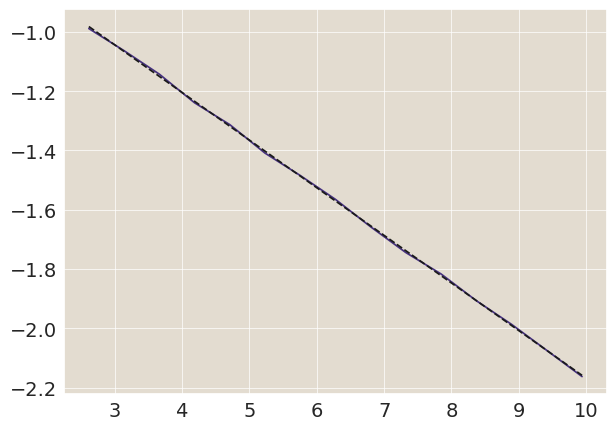

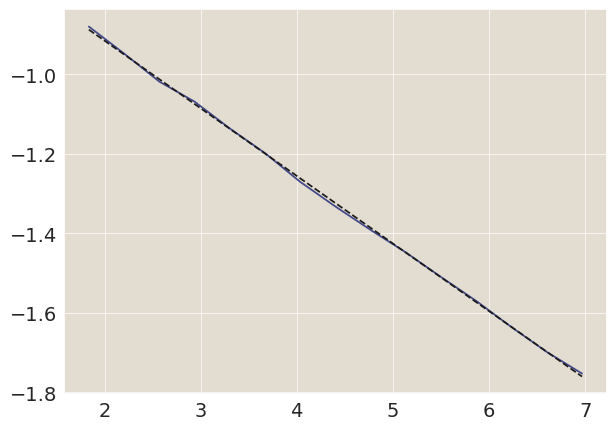

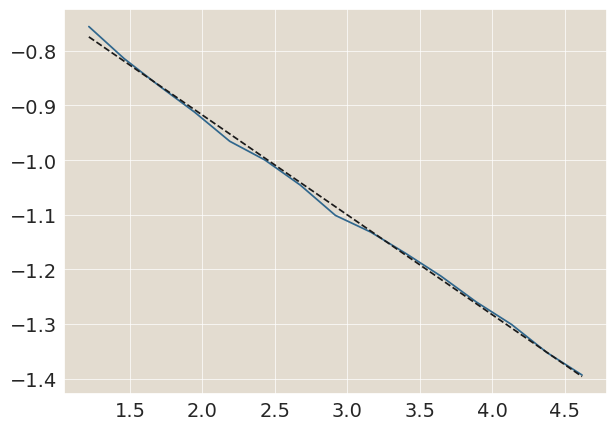

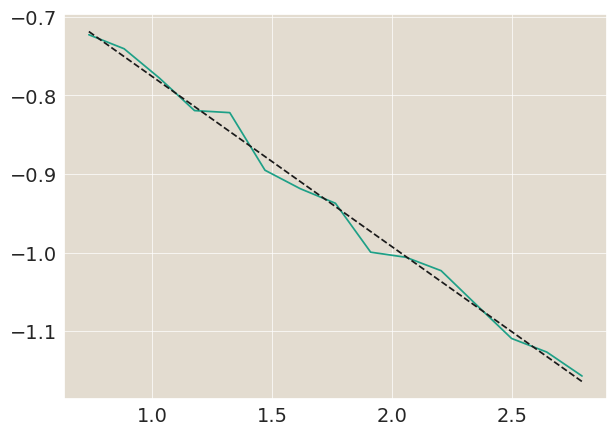

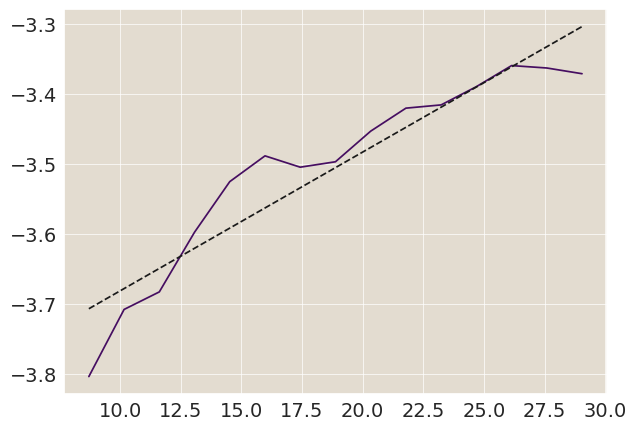

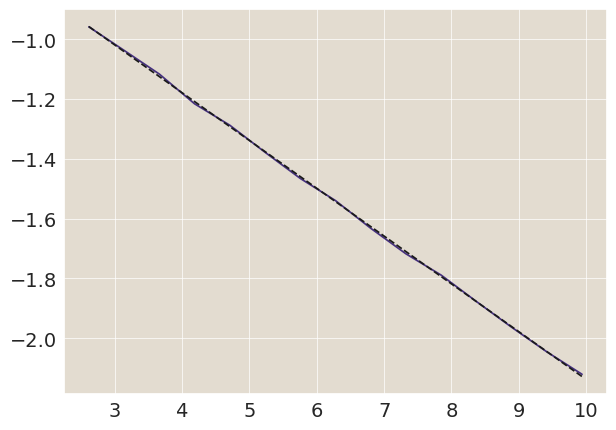

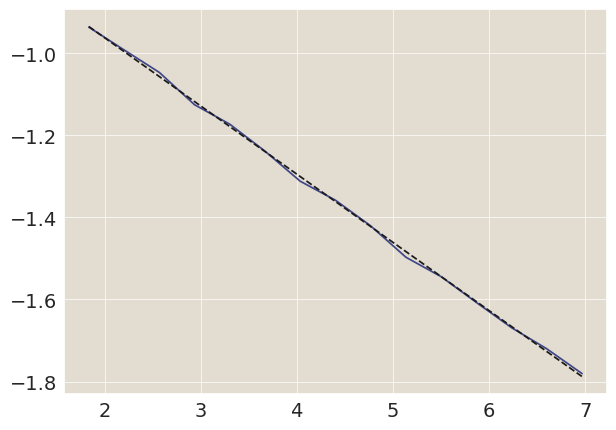

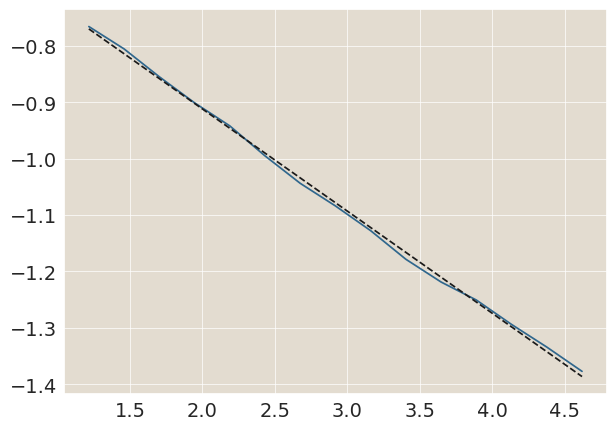

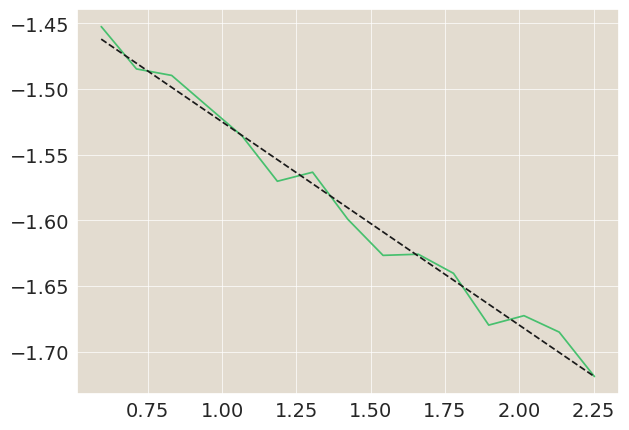

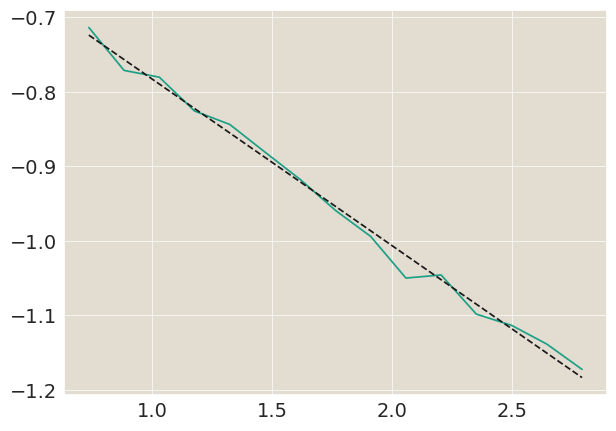

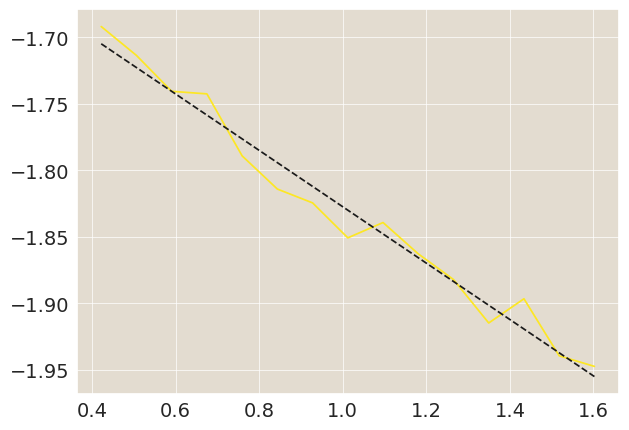

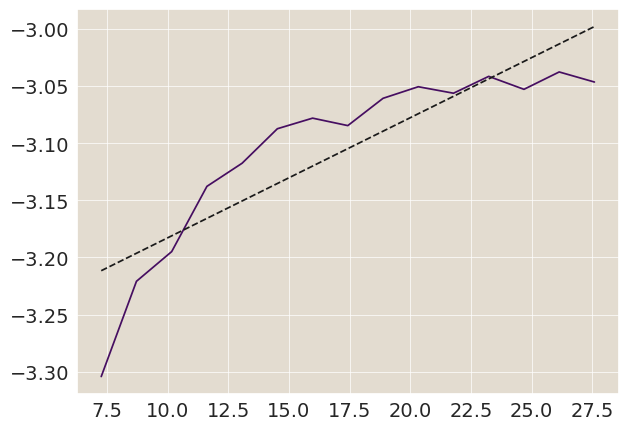

In [14]:
columns = fitting_information.columns

for row in fitting_information.values:
    i = row[np.where(columns == "Data Index")[-1]][0]
        
    y_o = row[np.where(columns == "Initial ATP Conc")[-1]][0]; 
    
    # Get time curve 
    time = np.array(times_list[i])

    # Generate a color
    color = plt.cm.viridis(y_o/1410);
    color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255),
                                         int(color[1] * 255),
                                         int(color[2] * 255))


    #### --------- With K_eff --------- ####

    K_eff = K_eff_func(y_o)
    
    # Non-dimensionalise time
    idealised_time_constant_K_eff = (K_T*(1 + (y_o*K_inv)))/(gamma*m);
    time_nd_K_eff = time/idealised_time_constant_K_eff; 
    
    # Non dimensionalise ATP 
    A_nd_K_eff = np.array(ATP_curve_list[i])/K_eff; 
    
    plt.figure()
    
    y_o = ATP_conc_list[i]; #initial ATP concentration (according to experimental plan)
    K_eff = K_eff_func(y_o)
    y3 = A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff));
    
    slope = row[np.where(columns == "Fitted Parameters (-Slope, Y-intercept)")[-1]][0][0]
    cutoff = row[np.where(columns == "Fitted Parameters (-Slope, Y-intercept)")[-1]][0][1]

    plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2], color = color)
    y = line(time_nd_K_eff[n1:n2], slope, cutoff)
    plt.plot(time_nd_K_eff[n1:n2], y, '--k')


### For dealing with ATP, ADP, P data together:

Starting from the original equation: 

\begin{align}
\frac{d[ATP]}{dt} = - \gamma \cdot m \cdot \frac{[ATP]}{1 + \frac{ATP}{K_T} + \frac{ADP}{K_D} + \frac{P}{K_P}}
\end{align}

Since ATP $\rightleftharpoons$ ADP + P, denoting y $= [ATP]$, 

\begin{align}
\frac{dy}{dt} = - \gamma \cdot m \cdot \frac{y}{1 + \frac{y}{K_T} + \frac{ADP_o + y_o - y}{K_D} + \frac{P_o + y_o - y}{K_P}}
\end{align}

Where $ADP_o$ and $P_o$ refers to the initial concentrations of ADP and Phosphate respectively. 

On reorganising and non-dimensionalizing, 

\begin{align}
K_{eff} = \frac{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})}{\frac{1}{K_T} - \frac{1}{K_D} - \frac{1}{K_P}} \,,
\end{align}

<!-- \begin{align}
\hat{t} = \frac{t * \gamma*m}{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})} \,,
\end{align}
 -->
 
\begin{align}
\hat{t} = \frac{t * \gamma*m}{K_T*(1 + \frac{y_o + ADP_o}{K_D} + \frac{y_o + P_o}{K_P})} \,,
\end{align}

\begin{align}
\hat{y} = \frac{y}{K_{eff}} \,,
\end{align}

leading to the following non-dimensionalised equation: 

\begin{align}
\frac{d\hat{y}}{d\hat{t}} = \frac{\hat{y}}{1 + \hat{y}} \,,
\end{align}

Non-dimensionalisation of ATP curve: 

\begin{align}
\hat{y} = \frac{y}{K}, \text{ where } K = K_T \text{ or } K = K_{eff}
\end{align}

Choice of rate constants: 

K_T = 28.1 uM

K_D = 34.6 uM

K_P = 9000 uM 

Initial ATP conc:  0
Initial ATP conc:  1000
[ 0.22901306 -0.59501713] [[0.00010262 0.00014601]
 [0.00014601 0.00023469]]
[1.09741235e-01 5.34554186e+02] [[3.41246362e-05 4.09495643e-02]
 [4.09495643e-02 5.55094104e+01]]


/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/723865005.py:80: RuntimeWarning: divide by zero encountered in divide
  plot1.line(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/723865005.py:82: RuntimeWarning: divide by zero encountered in divide
  plot1.circle(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/723865005.py:90: RuntimeWarning: divide by zero encountered in divide
  plot2.line(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/723865005.py:92: RuntimeWarning: divide by zero encountered in divide
  plot2.circle(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)),
/var/folders/f0/pddct2nd5dxf7qtf3z57b8_c0000gn/T/ipykernel_59380/723865005.py:96: RuntimeWarning: divide by zero encountered in divide
  y3 = A_nd_K_eff

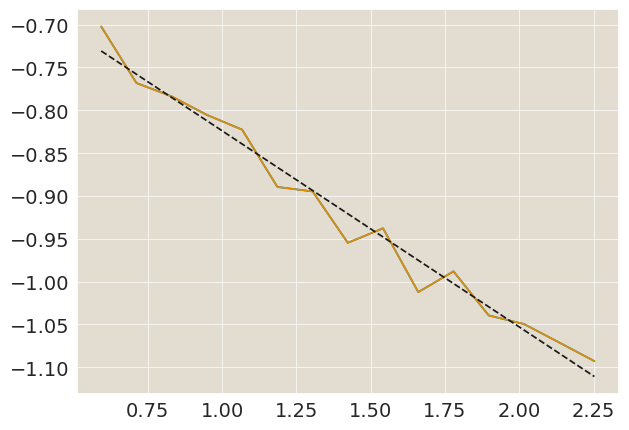

Initial ATP conc:  100
[ 0.14740217 -2.55507001] [[0.00023485 0.00257069]
 [0.00257069 0.03178725]]
[2.82766770e-03 5.32351618e+00] [[2.17248980e-07 2.60698775e-04]
 [2.60698775e-04 3.53391672e-01]]


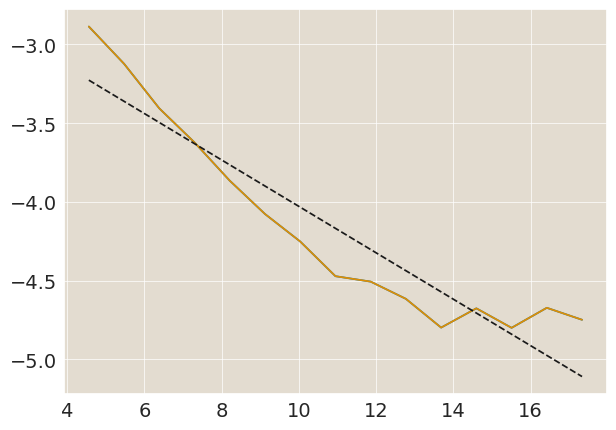

Initial ATP conc:  1420
[ 0.32452689 -0.87752472] [[0.000157   0.00015888]
 [0.00015888 0.00018163]]
[1.18392244e-01 5.72637077e+02] [[3.29665732e-05 3.95598878e-02]
 [3.95598878e-02 5.36256258e+01]]


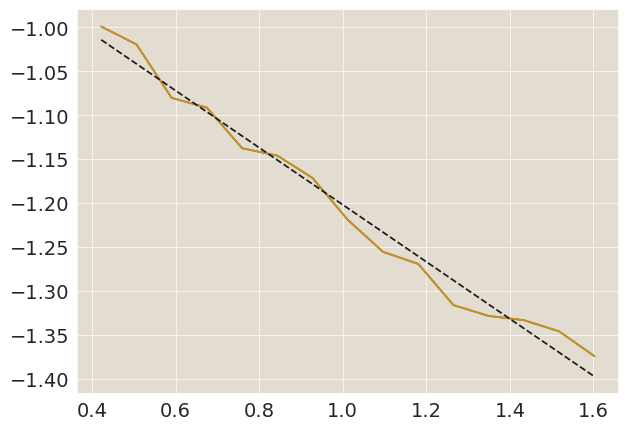

Initial ATP conc:  200
[ 0.15349985 -0.4678438 ] [[4.51512010e-07 2.83446617e-06]
 [2.83446617e-06 2.01006140e-05]]
[3.97899983e-02 9.87107233e+01] [[2.51338351e-06 3.01606023e-03]
 [3.01606023e-03 4.08843722e+00]]


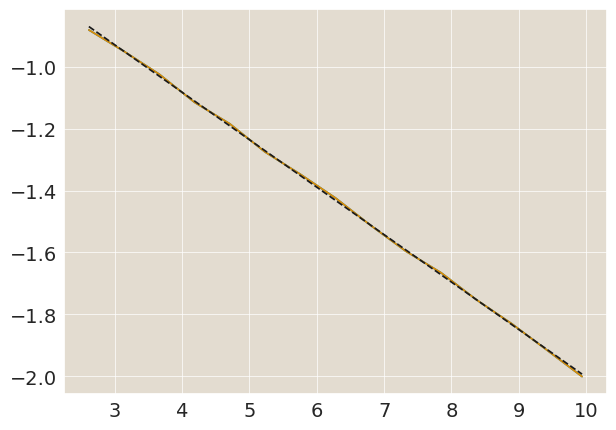

Initial ATP conc:  300
[ 0.1601521  -0.48509933] [[4.79701635e-07 2.11106639e-06]
 [2.11106639e-06 1.04946669e-05]]
[5.48547767e-02 1.60527150e+02] [[3.25644205e-06 3.90773044e-03]
 [3.90773044e-03 5.29714566e+00]]


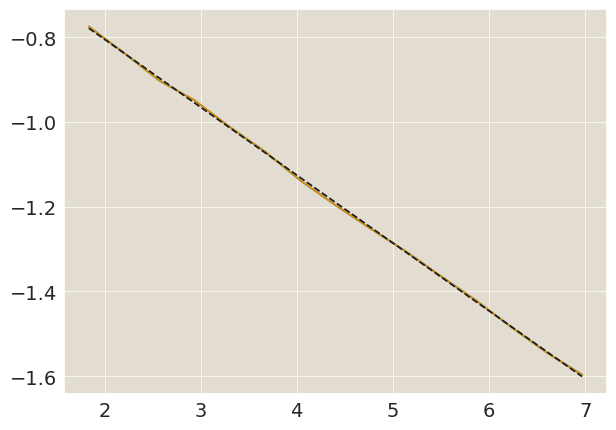

Initial ATP conc:  470
[ 0.16925911 -0.46732239] [[3.22085635e-06 9.39772598e-06]
 [9.39772598e-06 3.09749258e-05]]
[7.50640531e-02 2.73514741e+02] [[5.20235041e-06 6.24282048e-03]
 [6.24282048e-03 8.46248997e+00]]


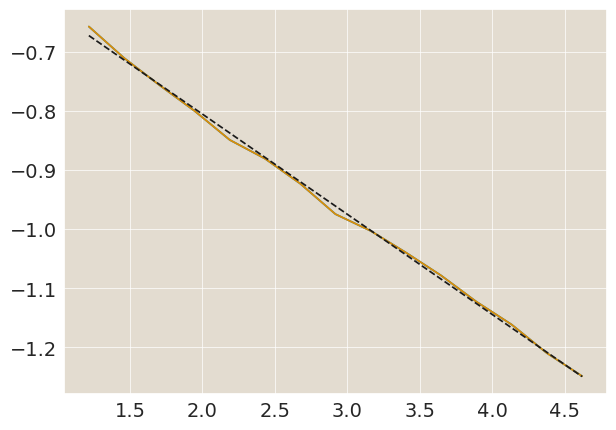

Initial ATP conc:  800
[ 0.19809882 -0.47544443] [[2.27010536e-05 4.00425012e-05]
 [4.00425012e-05 7.97870590e-05]]
[1.02882455e-01 4.78404194e+02] [[1.02974118e-05 1.23568941e-02]
 [1.23568941e-02 1.67504565e+01]]


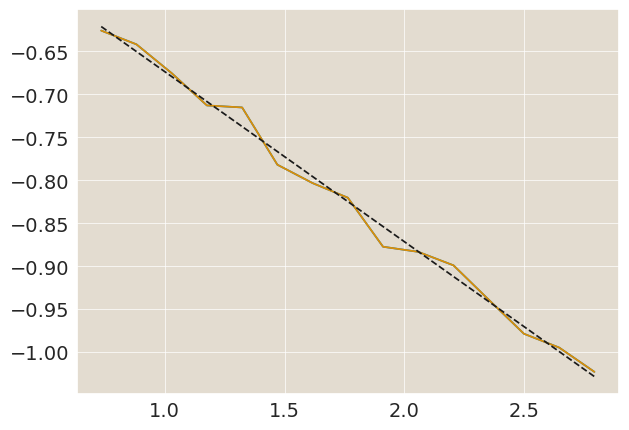

Initial ATP conc:  50
[-0.01974726 -3.75376991] [[3.82789667e-06 7.22632220e-05]
 [7.22632220e-05 1.51486827e-03]]
[-4.74406810e-04  1.10610926e+00] [[1.56581287e-09 2.03555672e-06]
 [2.03555672e-06 2.93850880e-03]]


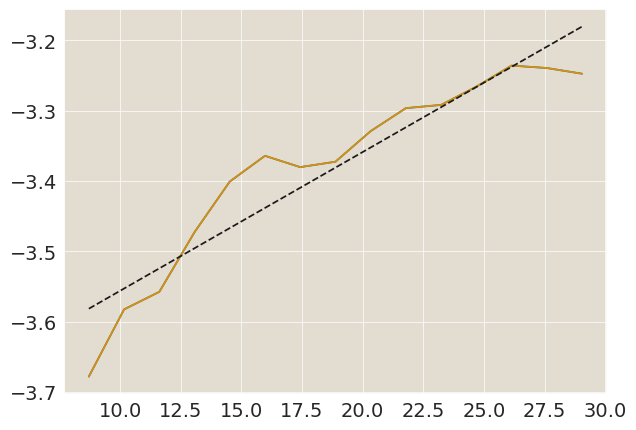

Initial ATP conc:  200
[ 0.15257481 -0.44744728] [[3.06384562e-07 1.92339663e-06]
 [1.92339663e-06 1.36397654e-05]]
[4.06717466e-02 1.01089045e+02] [[2.85582135e-06 3.42698565e-03]
 [3.42698565e-03 4.64546949e+00]]


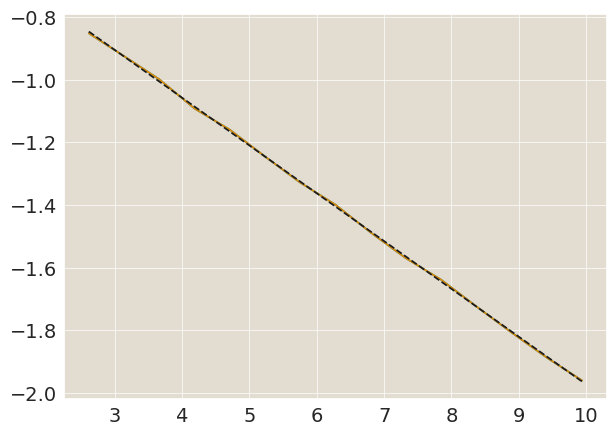

Initial ATP conc:  300
[ 0.15683873 -0.53498822] [[1.03919006e-06 4.57325762e-06]
 [4.57325762e-06 2.27348675e-05]]
[5.17992141e-02 1.53464192e+02] [[2.68705949e-06 3.22447140e-03]
 [3.22447140e-03 4.37095015e+00]]


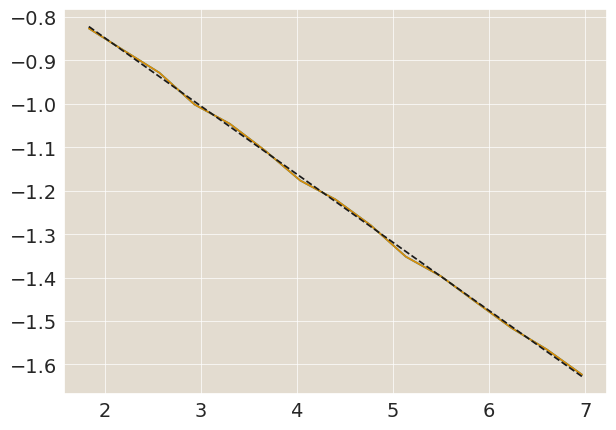

Initial ATP conc:  470
[ 0.16769938 -0.4653978 ] [[2.18176100e-06 6.36588212e-06]
 [6.36588212e-06 2.09819616e-05]]
[7.48392205e-02 2.74378856e+02] [[4.46283668e-06 5.35540399e-03]
 [5.35540399e-03 7.25954758e+00]]


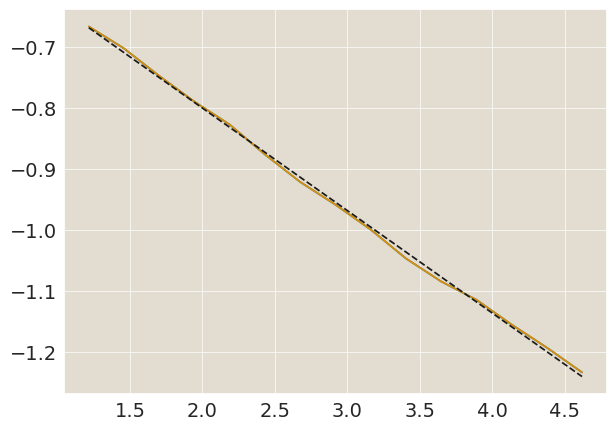

Initial ATP conc:  1000
[ 0.14724622 -1.2207503 ] [[2.74781886e-05 3.90981184e-05]
 [3.90981184e-05 6.28434019e-05]]
[4.21630145e-02 2.91956818e+02] [[2.81937736e-06 3.38325282e-03]
 [3.38325282e-03 4.58618715e+00]]


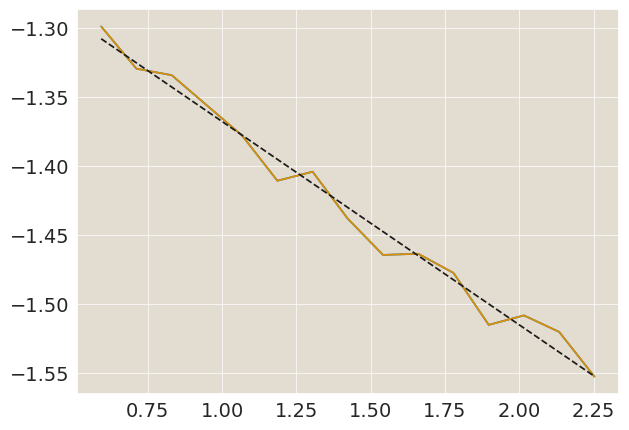

Initial ATP conc:  800
[ 0.20459868 -0.47517148] [[2.19663287e-05 3.87465161e-05]
 [3.87465161e-05 7.72047313e-05]]
[1.05187967e-01 4.77418140e+02] [[1.04282370e-05 1.25138844e-02]
 [1.25138844e-02 1.69632655e+01]]


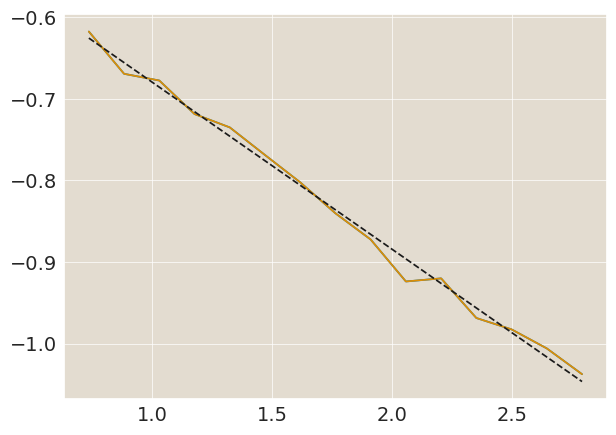

Initial ATP conc:  1420
[ 0.20348351 -1.45185625] [[8.81181440e-05 8.91755770e-05]
 [8.91755770e-05 1.01944216e-04]]
[4.70117940e-02 3.29509131e+02] [[5.85128659e-06 7.02154394e-03]
 [7.02154394e-03 9.51809291e+00]]


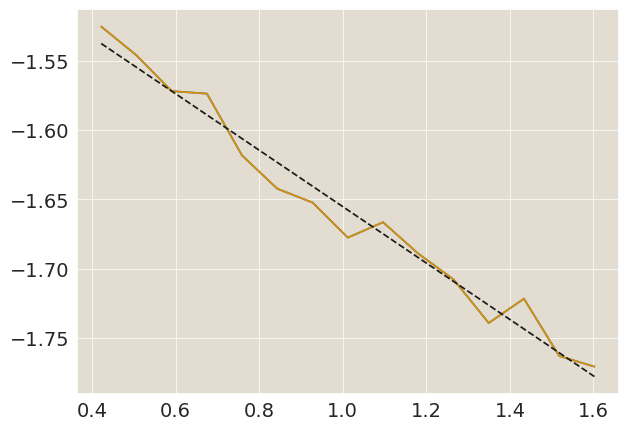

Initial ATP conc:  100
Initial ATP conc:  50
[-0.01043955 -3.16393157] [[2.65810443e-06 4.63198412e-05]
 [4.63198412e-05 9.11796973e-04]]
[-3.72993456e-04  2.10540206e+00] [[2.97489946e-09 3.56987937e-06]
 [3.56987937e-06 4.83916985e-03]]


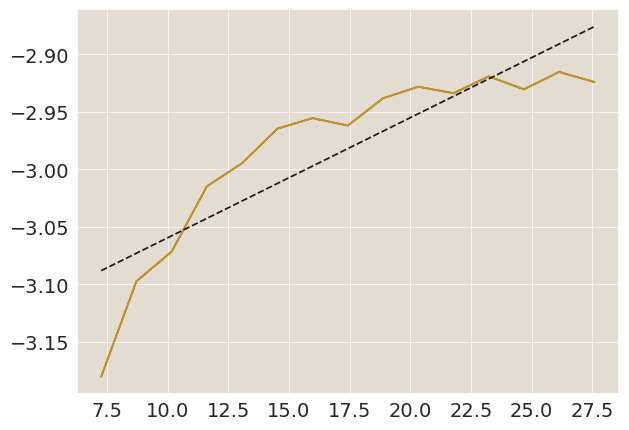

In [15]:
fitting_information = [];

# New K_eff function
K_eff_func_full = lambda y_o, ADP_o, P_o: K_T*(1 + (y_o + ADP_o)/(K_D) + (y_o + P_o)/(K_P))/((1/K_T) - (1/K_D) - (1/K_P)) # Units uM

# Pandas dataframe
m = 1; #motor concentration (uM)

# For an ideal curve
gamma = 1; # assume hydrolysis rate = 1 ATP/motor/s (s-1)

# Plotting properties
line_size = 2;
size = 600; 
plot1 = figure(title="Non dimensionalized ΑΤP vs Scaled Time (K_T and K_eff)", width=size, height=size)
plot2 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_T) vs Scaled Time", width=size, height=size)
plot3 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_eff) vs Scaled Time", width=size, height=size)
plot4 = figure(title="ATP vs Time", width=size, height=size)
plot5 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_eff) vs Time (s)", width=size, height=size)
plot6 = figure(title="log(ATP) vs Time", width=size, height=size)

n1, n2 = [5, 20]; # number of datapoints

for i in range(len(ATP_curve_list)): 
    
    #### --------- Reject Bad Curves --------- ####
    # ATP curve should not be empty 
    if len(ATP_curve_list[i]) != 0: 
        
    
    #     # If initial ATP value (according to probe) is too high, reject
        if ATP_curve_list[i][0] < 2000: 


            #### --------- Initialisations --------- ####

            # Initial ATP Concentration
            y_o = ATP_conc_list[i]; #initial ATP concentration (according to experimental plan)
        #     y_o = ATP_curve_list[i][0]; #initial ATP concentration
        #     y_o_exp = ATP_conc_list[i];
            print('Initial ATP conc: ', y_o) 


            # Initial ADP Concentration
            ADP_o = ADP_conc_list[i]; 
            P_o = P_conc_list[i]; 

            # Get time curve 
            time = np.array(times_list[i])

            # Generate a color
            color = plt.cm.viridis(y_o/800);
            color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255),
                                                 int(color[1] * 255),
                                                 int(color[2] * 255))

            A = ATP_curve_list[i]
            
            #### --------- With K_eff --------- ####

        #     K_eff = K_eff_func(y_o)
            K_eff = K_eff_func_full(y_o, ADP_o, P_o); 

            # Non-dimensionalise time
            idealised_time_constant_K_eff = (K_T*(1 + (y_o*K_inv)))/(gamma*m);
            time_nd_K_eff = time/idealised_time_constant_K_eff; 

            # Non dimensionalise ATP 
            A_nd_K_eff = np.array(ATP_curve_list[i])/K_eff; 

            #### --------- Plots --------- ####

            plot1.line(time_nd_K_T, A_nd + np.log(A_nd), line_color=color, line_dash="dotted")
            plot1.circle(time_nd_K_T, A_nd + np.log(A_nd), size = 1, fill_color="white", line_color=color)

            # Data
        #     plot1.line(time_nd_K_eff, A_nd_K_eff + np.log(A_nd_K_eff), line_color=color, line_dash="dotted")
        #     plot1.circle(time_nd_K_eff, A_nd_K_eff + np.log(A_nd_K_eff), size = 1, fill_color="white", line_color="blue")

            plot1.line(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)), 
                       line_color=color, line_dash="dotted")
            plot1.circle(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)), 
                         size = 1, fill_color="white", line_color=color)

            # Ideal curve (45 degree line)
            plot1.line(np.arange(0, np.amax(time_nd_K_eff)), - np.arange(0, np.amax(time_nd_K_eff)), 
                       line_color="black", line_dash="dotted")

        #     plot2.line(time_nd_K_T, A_nd + np.log(A_nd), line_color=color, line_dash="dotted")
            plot2.line(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)), 
                       line_color=color, line_dash="dotted")
            plot2.circle(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)), 
                         size = 1, fill_color="white", line_color=color) 

            # Data
            y3 = A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff));
            plot3.line(time_nd_K_eff, y3, 
                       line_color=color, line_dash="dotted")
            plot3.circle(time_nd_K_eff, y3, 
                         size = line_size, fill_color="white", line_color=color)


            plot4.line(time, A, 
                       line_color=color, line_dash="dotted", line_width = line_size)
            plot4.circle(time, A, 
                         size = line_size, fill_color="white", line_color=color)

            plot5.line(time, y3, 
                       line_color=color, line_dash="dotted")
            plot5.circle(time, y3, 
                         size = line_size, fill_color="white", line_color=color)

            plot6.line(time, np.log(A), 
                       line_color=color, line_dash="dotted")
            plot6.circle(time, np.log(A), 
                         size = line_size, fill_color="white", line_color=color)
            #### --------- Fitting --------- ####

            # Ignore if infs. This usually corresponds to y_o = 0; 
            if np.all(np.isinf(y3[n1:n2])) != True and len(y3[n1:n2]) >=2: 
                plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2])
                params, param_cov = fitting(time_nd_K_eff[n1:n2], y3[n1:n2], [1,1]);

                linear_params, linear_param_cov = fitting(time[n1:n2], A[n1:n2], [1,1]);

                plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2])
                plt.plot(time_nd_K_eff[n1:n2], line(time_nd_K_eff[n1:n2], params[0], params[1]), '--k')
                plt.show()

                fitting_information.append(
                {
                    'Data Location': data_locations_list[i],
                    'Data Index': i,
                    'Initial ATP Conc': y_o,
                    'Initial ADP Conc': ADP_o,
                    'Initial Phosphate Conc': P_o,
                    'Fitted Parameters (-Slope, Y-intercept)':  params, 
                    'Fitting Covariance Matrix': param_cov,
        #             'Hydrolysis Rate': params[0]*K_T*(1 + y_o*K_inv)/m,
                    'Hydrolysis Rate': params[0],
                    'Linear Hydrolysis Rate': linear_params[0]/m, 
                    'Time': time_nd_K_eff, 
                    'Non-Dimensionalised Data': y3
                }
                )

# Add color bar
mapper = linear_cmap(field_name='color', palette=Viridis256, low=0, high=800)
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0))
plot1.add_layout(color_bar, 'right')
plot2.add_layout(color_bar, 'right')
plot3.add_layout(color_bar, 'right')
plot4.add_layout(color_bar, 'right')
plot5.add_layout(color_bar, 'right')

# Labels 
plot1.xaxis.axis_label = "Scaled Time"
plot1.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_T/K_eff"

plot2.xaxis.axis_label = "Scaled Time"
plot2.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_T"
    
plot3.xaxis.axis_label = "Scaled Time"
plot3.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_eff"

plot4.xaxis.axis_label = "Time (s)"
plot4.yaxis.axis_label = "ATP (uM)"

plot5.xaxis.axis_label = "Time (s)"
plot5.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_eff"

# Ideal line 
plot3.line(np.arange(0,np.amax(time_nd_K_eff)), - np.arange(0,np.amax(time_nd_K_eff)), line_color="black")
    
# Arrange the plots in a grid layout
grid = gridplot([[plot4, plot6, plot2], [plot5, plot3]])

# Show the grid layout
show(grid)

fitting_information = pd.DataFrame(fitting_information)

In [16]:
# plot6 = figure(title="Non dimensionalized ΑΤP vs Time (K_eff)", width=size, height=size)
# plot7 = figure(title="From K_eff fit", width=size, height=size, y_range=(0, 1))
# plot8 = figure(title="From Linear fit", width=size, height=size)
circle_size = 10;

# plt.figure()
# plt.hist(fitting_information["Hydrolysis Rate"], bins = 100);
# plt.xlabel("Hydrolysis Rate (s-1)")
# plt.ylabel("Count")

# plt.figure()
plot7.circle(fitting_information["Initial ATP Conc"], fitting_information["Hydrolysis Rate"], size = circle_size, color = "#35B778");
plot7.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot7.xaxis.axis_label = "ATP[t=0] (uM), Experimental Plan"

plot8.circle(fitting_information["Initial ATP Conc"], fitting_information["Linear Hydrolysis Rate"], size = circle_size, color = "#35B778");
plot8.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot8.xaxis.axis_label = "ATP[t=0] (uM), Experimental Plan"

plot9.circle(fitting_information["Initial ADP Conc"], fitting_information["Hydrolysis Rate"], size = circle_size, color = "#35B778");
plot9.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot9.xaxis.axis_label = "ADP[t=0] (uM), Experimental Plan"

plot10.circle(fitting_information["Initial ADP Conc"], fitting_information["Linear Hydrolysis Rate"], size = circle_size, color = "#35B778");
plot10.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot10.xaxis.axis_label = "ADP[t=0] (uM), Experimental Plan"

plot11.circle(fitting_information["Initial Phosphate Conc"], fitting_information["Hydrolysis Rate"], size = circle_size, color = "#35B778");
plot11.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot11.xaxis.axis_label = "P[t=0] (uM), Experimental Plan"

plot12.circle(fitting_information["Initial Phosphate Conc"], fitting_information["Linear Hydrolysis Rate"], size = circle_size, color = "#35B778");
plot12.yaxis.axis_label = "Hydrolysis Rate (s-1)"
plot12.xaxis.axis_label = "P[t=0] (uM), Experimental Plan"

# # Arrange the plots in a grid layout
grid = gridplot([[plot7, plot8], [plot9, plot10], [plot11, plot12]])

# # Show the grid layout
show(grid)

## Adjusted Initial Conditions

Initial ATP conc:  497.41083674032376
K_eff 128280.63574199166
[0.11774858 0.10723972] [[2.71280108e-05 7.50741213e-05]
 [7.50741213e-05 2.34692192e-04]]
[1.09741235e-01 5.34554186e+02] [[3.41246362e-05 4.09495643e-02]
 [4.09495643e-02 5.55094104e+01]]


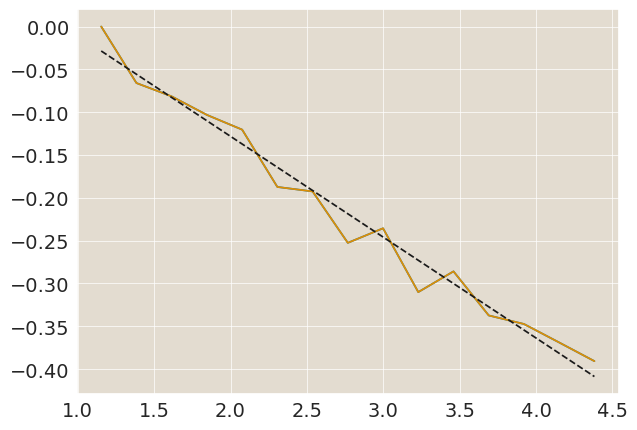

Initial ATP conc:  525.3618524770862
K_eff 180363.3424938996
[0.12491147 0.12176037] [[2.32594065e-05 6.11543812e-05]
 [6.11543812e-05 1.81632097e-04]]
[1.18392244e-01 5.72637077e+02] [[3.29665732e-05 3.95598878e-02]
 [3.95598878e-02 5.36256258e+01]]


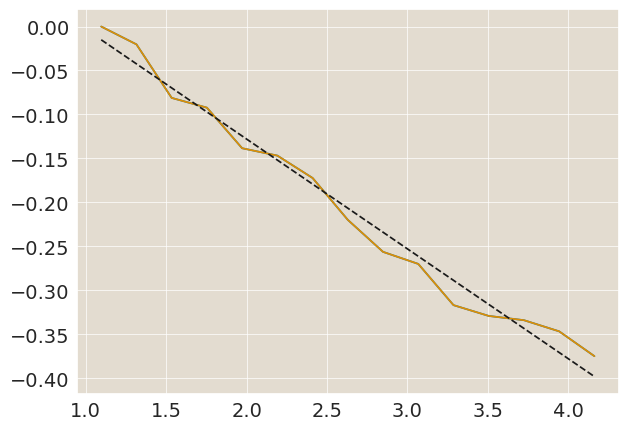

Initial ATP conc:  244.32631967532393
K_eff 62557.22007886981
[0.093541   0.19051307] [[9.83719421e-07 5.19365051e-06]
 [5.19365051e-06 3.09749257e-05]]
[7.50640531e-02 2.73514741e+02] [[5.20235041e-06 6.24282048e-03]
 [6.24282048e-03 8.46248997e+00]]


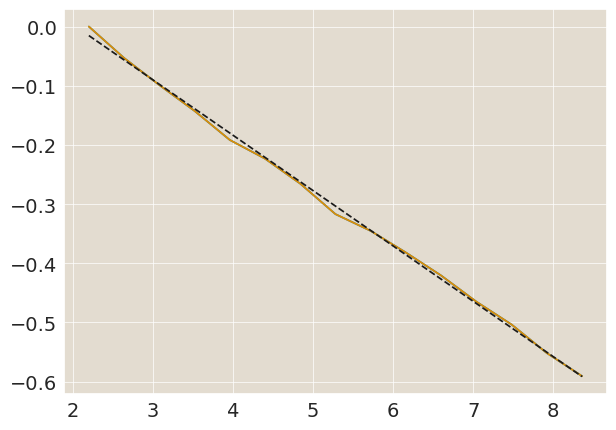

Initial ATP conc:  429.42778445005064
K_eff 103479.34681251172
[0.11012665 0.15029483] [[7.01563626e-06 2.22603365e-05]
 [2.22603365e-05 7.97870596e-05]]
[1.02882455e-01 4.78404194e+02] [[1.02974118e-05 1.23568941e-02]
 [1.23568941e-02 1.67504565e+01]]


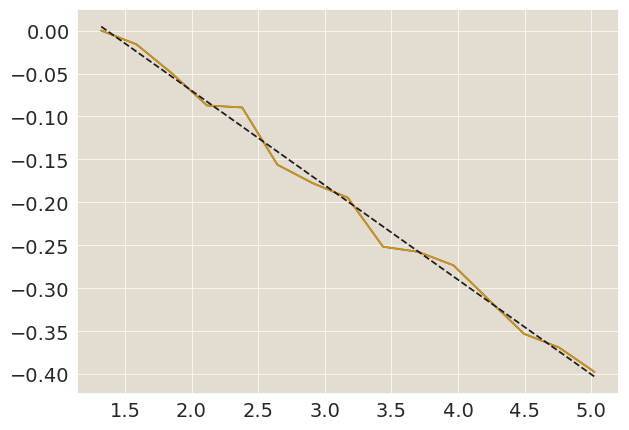

Initial ATP conc:  242.03587621660475
K_eff 62557.22007886981
[0.0919176  0.20189302] [[6.55453187e-07 3.48919993e-06]
 [3.48919993e-06 2.09819624e-05]]
[7.48392205e-02 2.74378856e+02] [[4.46283668e-06 5.35540399e-03]
 [5.35540399e-03 7.25954758e+00]]


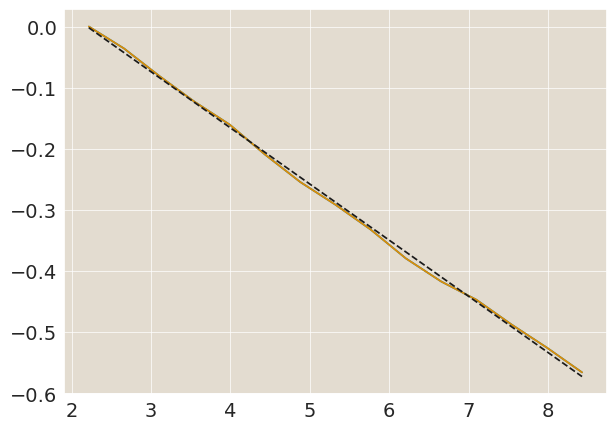

Initial ATP conc:  274.3021049743644
K_eff 128280.63574199166
[0.0439503  0.07843202] [[2.44806788e-06 1.16700718e-05]
 [1.16700718e-05 6.28434004e-05]]
[4.21630145e-02 2.91956818e+02] [[2.81937736e-06 3.38325282e-03]
 [3.38325282e-03 4.58618715e+00]]


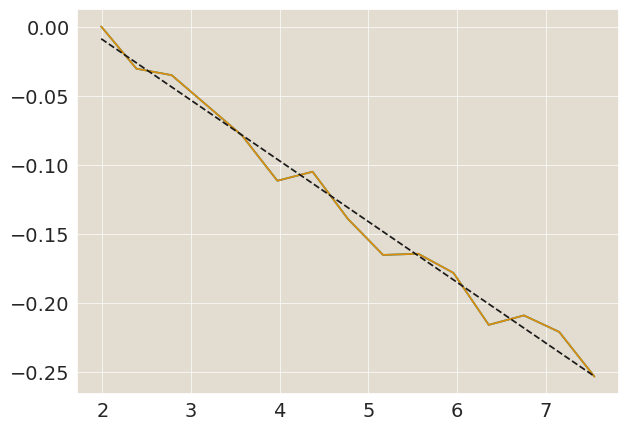

Initial ATP conc:  432.9519231872425
K_eff 103479.34681251172
[0.1146041  0.14236062] [[6.89210900e-06 2.17035109e-05]
 [2.17035109e-05 7.72047327e-05]]
[1.05187967e-01 4.77418140e+02] [[1.04282370e-05 1.25138844e-02]
 [1.25138844e-02 1.69632655e+01]]


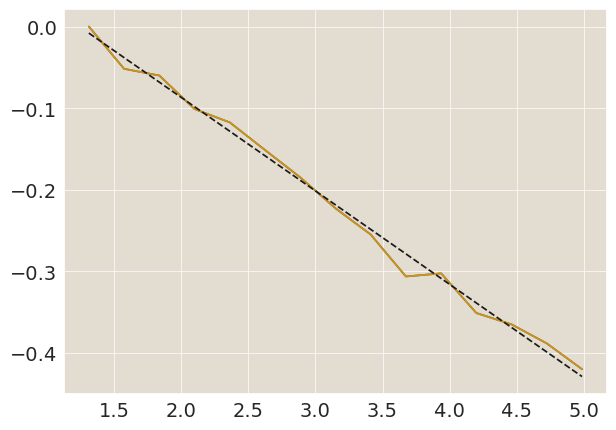

Initial ATP conc:  310.8003897124423
K_eff 180363.3424938996
[0.04830381 0.07355484] [[4.96557643e-06 2.11688905e-05]
 [2.11688905e-05 1.01944218e-04]]
[4.70117940e-02 3.29509131e+02] [[5.85128659e-06 7.02154394e-03]
 [7.02154394e-03 9.51809291e+00]]


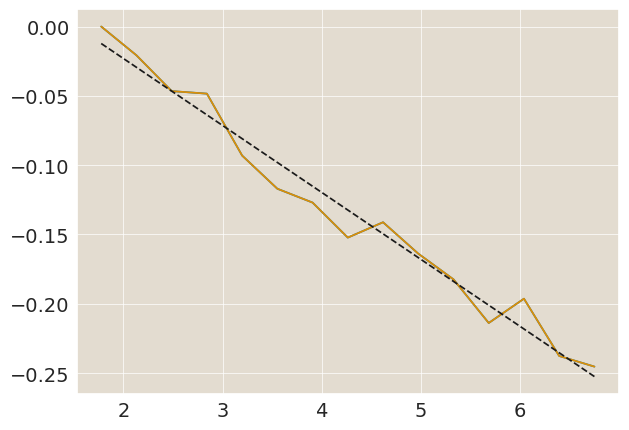

In [25]:
fitting_information_adjusted_initial_conditions = [];

# New K_eff function
K_eff_func_full = lambda y_o, ADP_o, P_o: K_T*(1 + (y_o + ADP_o)/(K_D) + (y_o + P_o)/(K_P))/((1/K_T) - (1/K_D) - (1/K_P)) # Units uM

# Pandas dataframe
m = 1; #motor concentration (uM)

# For an ideal curve
gamma = 1; # assume hydrolysis rate = 1 ATP/motor/s (s-1)

# Plotting properties
line_size = 2;
size = 600; 
plot1 = figure(title="Non dimensionalized ΑΤP vs Scaled Time (K_T and K_eff)", width=size, height=size)
plot2 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_T) vs Scaled Time", width=size, height=size)
plot3 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_eff) vs Scaled Time", width=size, height=size)
plot4 = figure(title="ATP vs Time", width=size, height=size)
plot5 = figure(title="y - y0 + ln(y/y0) non-dimensionalised (K_eff) vs Time (s)", width=size, height=size)
plot6 = figure(title="log(ATP) vs Time", width=size, height=size)

n1, n2 = [5, 20]; # number of datapoints

nondimensionalised_y = []; 
nondimensionalised_time = [];

for i in range(len(ATP_curve_list)): 
    
    #### --------- Reject Bad Curves --------- ####
    # ATP curve should not be empty 
    if len(ATP_curve_list[i]) != 0: 
    
        if ATP_curve_list[i][0] > 200: 


            #### --------- Initialisations --------- ####

            # Initial ATP Concentration
            y_o = ATP_curve_list[i][n1]; #initial ATP concentration, first measurement of ATP
            print('Initial ATP conc: ', y_o) 

            # Adjusted ADP and P concentrations based on amount of ATP hydrolysed
            ADP_o = ADP_conc_list[i] + ATP_conc_list[i] - y_o; 
            P_o = P_conc_list[i] + ATP_conc_list[i] - y_o; 

            # Get time curve 
            time = np.array(times_list[i])

            # Generate a color
            color = plt.cm.viridis(y_o/800);
            color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255),
                                                 int(color[1] * 255),
                                                 int(color[2] * 255))

            A = ATP_curve_list[i]
            #### --------- With K_eff --------- ####

            K_eff = K_eff_func_full(y_o, ADP_o, P_o); 
            print('K_eff', K_eff)
            
            # Non-dimensionalise time
            idealised_time_constant_K_eff = (K_T*(1 + (y_o*K_inv)))/(gamma*m);
            time_nd_K_eff = time/idealised_time_constant_K_eff; 

            # Non dimensionalise ATP 
            A_nd_K_eff = np.array(ATP_curve_list[i])/K_eff; 

            #### --------- Plots --------- ####

            plot1.line(time_nd_K_T, A_nd + np.log(A_nd), line_color=color, line_dash="dotted")
            plot1.circle(time_nd_K_T, A_nd + np.log(A_nd), size = 1, fill_color="white", line_color=color)

            # Data
        #     plot1.line(time_nd_K_eff, A_nd_K_eff + np.log(A_nd_K_eff), line_color=color, line_dash="dotted")
        #     plot1.circle(time_nd_K_eff, A_nd_K_eff + np.log(A_nd_K_eff), size = 1, fill_color="white", line_color="blue")

            plot1.line(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)), 
                       line_color=color, line_dash="dotted")
            plot1.circle(time_nd_K_eff, A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff)), 
                         size = 1, fill_color="white", line_color=color)

            # Ideal curve (45 degree line)
            plot1.line(np.arange(0, np.amax(time_nd_K_eff)), - np.arange(0, np.amax(time_nd_K_eff)), 
                       line_color="black", line_dash="dotted")

        #     plot2.line(time_nd_K_T, A_nd + np.log(A_nd), line_color=color, line_dash="dotted")
            plot2.line(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)), 
                       line_color=color, line_dash="dotted")
            plot2.circle(time_nd_K_T, A_nd - y_o/K_T + np.log(A_nd/(y_o/K_T)), 
                         size = 1, fill_color="white", line_color=color) 

            # Data
            y3 = A_nd_K_eff - y_o/K_eff + np.log(A_nd_K_eff/(y_o/K_eff));
            nondimensionalised_y.append(y3)
            nondimensionalised_time.append(time_nd_K_eff)
            
            plot3.line(time_nd_K_eff, y3, 
                       line_color=color, line_dash="dotted")
            plot3.circle(time_nd_K_eff, y3, 
                         size = line_size, fill_color="white", line_color=color)


            plot4.line(time, A, 
                       line_color=color, line_dash="dotted", line_width = line_size)
            plot4.circle(time, A, 
                         size = line_size, fill_color="white", line_color=color)

            plot5.line(time, y3, 
                       line_color=color, line_dash="dotted")
            plot5.circle(time, y3, 
                         size = line_size, fill_color="white", line_color=color)

            plot6.line(time, np.log(A), 
                       line_color=color, line_dash="dotted")
            plot6.circle(time, np.log(A), 
                         size = line_size, fill_color="white", line_color=color)
            
            #### --------- Fitting --------- ####

            # Ignore if infs. This usually corresponds to y_o = 0; 
            if np.all(np.isinf(y3[n1:n2])) != True and len(y3[n1:n2]) >=2: 
                plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2])
                params, param_cov = fitting(time_nd_K_eff[n1:n2], y3[n1:n2], [1,1]);

                linear_params, linear_param_cov = fitting(time[n1:n2], A[n1:n2], [1,1]);

                plt.plot(time_nd_K_eff[n1:n2], y3[n1:n2])
                plt.plot(time_nd_K_eff[n1:n2], line(time_nd_K_eff[n1:n2], params[0], params[1]), '--k')
                plt.show()

                fitting_information_adjusted_initial_conditions.append(
                {
                    'Data Location': data_locations_list[i],
                    'Data Index': i,
                    'Initial ATP Conc': y_o,
                    'Initial ADP Conc': ADP_o,
                    'Initial Phosphate Conc': P_o,
                    'Fitted Parameters (-Slope, Y-intercept)':  params, 
                    'Fitting Covariance Matrix': param_cov,
        #             'Hydrolysis Rate': params[0]*K_T*(1 + y_o*K_inv)/m,
                    'Hydrolysis Rate': params[0],
                    'Linear Hydrolysis Rate': linear_params[0]/m, 
                    'Time': time, 
                    'Non-Dimensionalised Data': y3
                }
                )

# Add color bar
mapper = linear_cmap(field_name='color', palette=Viridis256, low=0, high=800)
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0))
plot1.add_layout(color_bar, 'right')
plot2.add_layout(color_bar, 'right')
plot3.add_layout(color_bar, 'right')
plot4.add_layout(color_bar, 'right')
plot5.add_layout(color_bar, 'right')

# Labels 
plot1.xaxis.axis_label = "Scaled Time"
plot1.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_T/K_eff"

plot2.xaxis.axis_label = "Scaled Time"
plot2.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_T"
    
plot3.xaxis.axis_label = "Scaled Time"
plot3.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_eff"

plot4.xaxis.axis_label = "Time (s)"
plot4.yaxis.axis_label = "ATP (uM)"

plot5.xaxis.axis_label = "Time (s)"
plot5.yaxis.axis_label = "y - y0 + ln(y/y0) non-dimensionalised K_eff"

# Ideal line 
plot3.line(np.arange(0,np.amax(time_nd_K_eff)), - np.arange(0,np.amax(time_nd_K_eff)), line_color="black")
    
# Arrange the plots in a grid layout
grid = gridplot([[plot4, plot6, plot2], [plot5, plot3]])

# Show the grid layout
show(grid)

fitting_information_adjusted_initial_conditions = pd.DataFrame(fitting_information_adjusted_initial_conditions)

In [18]:
fitting_information_adjusted_initial_conditions

,Data Location,Data Index,Initial ATP Conc,Initial ADP Conc,Initial Phosphate Conc,"Fitted Parameters (-Slope, Y-intercept)",Fitting Covariance Matrix,Hydrolysis Rate,Linear Hydrolysis Rate,Time,Non-Dimensionalised Data
0,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,0,8.338846,-8.338846,-8.338846,"[0.0007002776306655488, 0.009729336037232063]","[[5.683911357454246e-09, 1.9544467093214134e-0...",0.000700,0.000165,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.3868715942008427, 0.0, -0.0011213021707295..."
1,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1,566.848906,433.151094,433.151094,"[0.13312096267633455, -0.02397804463794828]","[[3.467363618037881e-05, 8.487522902589293e-05...",0.133121,0.109741,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.4431046232286534, 0.0, -0.0084593321108225..."
2,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,2,14.938782,85.061218,85.061218,"[0.05415875411929285, -0.6487592761651013]","[[3.170383965931355e-05, 0.0009445269836389287...",0.054159,0.002828,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[0.0314155172594169, 0.0, -0.23505611262399875..."
3,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,3,631.727645,788.272355,788.272355,"[0.148644255104723, -0.063200457541021]","[[3.293746727853353e-05, 7.277351334012112e-05...",0.148644,0.118392,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.506690347000504, 0.0, -0.07875112896945823..."
4,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,4,115.627490,84.372510,84.372510,"[0.09826333135165985, 0.08300167453546728]","[[1.8502750007761558e-07, 1.8144905724111994e-...",0.098263,0.039790,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.14433104218775727, 0.0, -0.087494752905252..."
5,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,5,179.120320,120.879680,120.879680,"[0.10227163002229234, 0.033539825525839104]","[[1.9562142493416392e-07, 1.3481076310935153e-...",0.102272,0.054855,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.1149001094985461, 0.0, -0.0711577059275977..."
6,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,6,296.137141,173.862859,173.862859,"[0.1109245841144475, -0.0026330902880145057]","[[1.383315954342672e-06, 6.158814435458259e-06...",0.110925,0.075064,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.16398158753211034, 0.0, -0.069690562239807..."
7,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,7,533.596974,266.403026,266.403026,"[0.13485594198171402, -0.06789907207983285]","[[1.0520161570257046e-05, 2.725896653956049e-0...",0.134856,0.102882,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.2639290314559975, 0.0, -0.0713155255939009..."
8,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,8,0.984388,49.015612,49.015612,"[-0.008288129422922673, 0.17866803062287903]","[[6.743098364693082e-07, 3.0329618384778968e-0...",-0.008288,-0.000474,"[100, 200, 300, 400, 500, 600, 700, 800, 900, ...","[0.17345967348043598, 0.0, -0.1374340897293990..."
9,/Volumes/Najma/ATP/2_variation of ATP/200uMATP_2,9,118.233514,81.766486,81.766486,"[0.09936697902796394, 0.0810206954885983]","[[1.2995274935477148e-07, 1.2526454847154448e-...",0.099367,0.040672,"[0, 100, 200, 300, 400, 500, 600, 700, 800, 90...","[-0.022358080329765412, 0.0, -0.08027184946025..."


In [45]:
n1, n2 = [5, 20]; # number of datapoints
slope_list = fitting_information_adjusted_initial_conditions["Hydrolysis Rate"].values

MotConc = 1; #uM

plt.figure()

tau_list = np.zeros(len(fitting_information_adjusted_initial_conditions)); 

p = figure(title = "Adjusted Initial Conditions, Data Collapse")

for i, row in fitting_information_adjusted_initial_conditions.iterrows():
    print(i)
    y0 = row["Initial ATP Conc"]; 

    # Generate a color
    color = plt.cm.viridis(y_o/1410); 
    color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255),
                                        int(color[1] * 255),
                                        int(color[2] * 255))
    nondimensionalised_y = row["Non-Dimensionalised Data"][n1:n2]
    
    time = row["Time"][n1:n2] - row["Time"][n1]
    gamma_adjusted = gamma*slope_list[i]; 
    print("gamma_adjusted", gamma_adjusted)
    Ktime = (K_T*(1 + (y0*K_inv)))/(gamma_adjusted*MotConc); 
    nondimensionalised_t = time/Ktime;
    
    print(len(nondimensionalised_y), len(nondimensionalised_t))
    # # Shade the area representing the standard deviation
    # plt.fill_between(nondimensionalised_t, nondimensionalised_y_average[i] - nondimensionalised_y_std[i], nondimensionalised_y_average[i] + nondimensionalised_y_std[i], alpha=0.4, color=colormap[i], label='± 1 Std. Dev.')

    tau_list[i] = - nondimensionalised_y[0]*Ktime/slope_list[i]
    print("Time Delay: ", nondimensionalised_y[n1]*Ktime/slope_list[i])
    
    if len(nondimensionalised_y) == len(nondimensionalised_t) and slope_list[i]>0:
    
        p.line(nondimensionalised_t, nondimensionalised_y, color=color)
#         p.circle(nondimensionalised_t - nondimensionalised_y[0], nondimensionalised_y, color=color)
        
p.line(np.arange(0, 5, 0.01), - np.arange(0, 5, 0.01), color = "black", alpha = 0.5, legend_label = "Ideal Line")
p.x_range = Range1d(0, 5)
show(p)
print('tau list', tau_list)

0
gamma_adjusted 0.1177485845598972
15 15
Time Delay:  -5857.69203576149
1
gamma_adjusted 0.12491147330420091
15 15
Time Delay:  -4295.353218385911
2
gamma_adjusted 0.09354099805004372
15 15
Time Delay:  -5797.757922584225
3
gamma_adjusted 0.11012664602758902
15 15
Time Delay:  -4871.024291991239
4
gamma_adjusted 0.09191760250751843
15 15
Time Delay:  -5588.829271337281
5
gamma_adjusted 0.04395029809900515
15 15
Time Delay:  -14553.090842303392
6
gamma_adjusted 0.11460409962064194
15 15
Time Delay:  -4390.970708037864
7
gamma_adjusted 0.04830380945002274
15 15
Time Delay:  -14115.906148229391
tau list [-0. -0. -0. -0. -0. -0. -0. -0.]


<Figure size 700x500 with 0 Axes>

In [20]:
fitting_information

,Data Location,Data Index,Initial ATP Conc,Initial ADP Conc,Initial Phosphate Conc,"Fitted Parameters (-Slope, Y-intercept)",Fitting Covariance Matrix,Hydrolysis Rate,Linear Hydrolysis Rate,Time,Non-Dimensionalised Data
0,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,1,1000,0,0,"[0.22901305819233797, -0.5950171287253367]","[[0.0001026188251877348, 0.0001460140997282746...",0.229013,0.109741,"[0.0, 0.11857319210151755, 0.2371463842030351,...","[-1.0141437043197623, -0.5710390810911089, -0...."
1,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,2,100,0,0,"[0.1474021678436901, -2.5550700063006424]","[[0.0002348455227021177, 0.002570689272206191]...",0.147402,0.002828,"[0.0, 0.912191572181801, 1.824383144363602, 2....","[-1.8748952118659752, -1.906310729125392, -2.1..."
2,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,3,1420,0,0,"[0.32452689316157146, -0.8775247157398031]","[[0.00015699846198959525, 0.000158882471386810...",0.324527,0.118392,"[0.0, 0.08433334764382316, 0.16866669528764633...","[-1.3210146063863495, -0.8143242593858455, -0...."
3,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,4,200,0,0,"[0.15349984758646584, -0.46784380499689165]","[[4.5151200955791025e-07, 2.8344661728891528e-...",0.153500,0.039790,"[0.0, 0.5231433652048713, 1.0462867304097425, ...","[-0.6951765214582719, -0.5508454792705146, -0...."
4,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,5,300,0,0,"[0.16015209543923017, -0.4850993322291373]","[[4.797016349966138e-07, 2.111066389031504e-06...",0.160152,0.054855,"[0.0, 0.36673253955641477, 0.7334650791128295,...","[-0.6335392670191043, -0.5186391575205583, -0...."
5,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,6,470,0,0,"[0.16925911102268906, -0.46732239147208715]","[[3.2208563471150276e-06, 9.397725979607068e-0...",0.169259,0.075064,"[0.0, 0.24314770454254458, 0.48629540908508917...","[-0.628670883825463, -0.46468929629335276, -0...."
6,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,7,800,0,0,"[0.19809881882905034, -0.4754444329363592]","[[2.270105357698714e-05, 4.0042501192534944e-0...",0.198099,0.102882,"[0.0, 0.14699208038391726, 0.2939841607678345,...","[-0.6714743921242656, -0.407545360668268, -0.4..."
7,/Volumes/Najma/ATP/1_variation of ATP/Nikon_10...,8,50,0,0,"[-0.01974726073873974, -3.7537699147847534]","[[3.827896672692976e-06, 7.226322199408273e-05...",-0.019747,-0.000474,"[1.4521576315710074, 2.904315263142015, 4.3564...","[-3.758978270108505, -3.9324379435889414, -4.0..."
8,/Volumes/Najma/ATP/2_variation of ATP/200uMATP_2,9,200,0,0,"[0.15257480572657997, -0.447447279859599]","[[3.0638456226585463e-07, 1.923396634338241e-0...",0.152575,0.040672,"[0.0, 0.5231433652048713, 1.0462867304097425, ...","[-0.5508260563467815, -0.5284679760170161, -0...."
9,/Volumes/Najma/ATP/2_variation of ATP/300uMATP_2,10,300,0,0,"[0.15683873181514787, -0.5349882223057023]","[[1.0391900565142876e-06, 4.573257622609799e-0...",0.156839,0.051799,"[0.0, 0.36673253955641477, 0.7334650791128295,...","[-0.6569225405622776, -0.5797687159038838, -0...."


In [21]:
len(fitting_information_adjusted_initial_conditions)

16

In [ ]:
plt.figure()
plt.scatter(tau_list, row["Non-Dimensionalised Data"][n1])
plt.xlabel("Time Delay (s)")
plt.xlabel("Initial ATP measured")

In [41]:
fitting_information_adjusted_initial_conditions["Non-Dimensionalised Data"].values

IndexError: index 5 is out of bounds for axis 1 with size 1

(array([0., 0., 0., 0., 0., 8., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

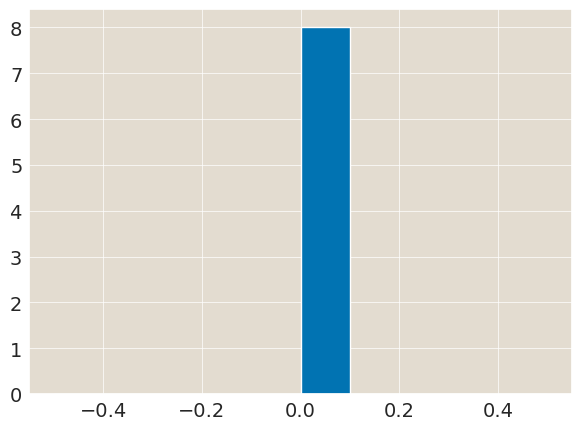

In [46]:
plt.hist(tau_list)

In [43]:
tau_list

array([-0., -0., -0., -0., -0., -0., -0., -0.])